In [115]:
# Con esto se evalúa el BIC - Bayesian Information Criterion
# De esta manera vemos cual es número ideal de componentes y el mejor método para el clustering
Xbic=XprojL
# H, full, 2 components
# D, full, 6 components
# B, tied, 5 components
# L, full, 11 components
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for kcomp in np.arange(25)+1:
        gmm = GMM(kcomp, covariance_type=cv_type, random_state=0)
        gmm.fit(Xbic)
#        print cv_type,kcomp,gmm.bic(Xbic)

In [1]:
from sklearn.decomposition import PCA
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GMM

In [2]:
# función para convertir los datos de LONLAT a formato legible por el computador
def conversion(old):
    direction = {'N':-1, 'S':1, 'E': -1, 'W':1} # diccionario
    new = old.replace('\xc2\xb0',' ').replace('\'',' ').replace('"',' ')
    new = new.split() # separa grados, minutos, segundos, orientación en una lista de 4 objetos
    new_dir = new.pop() # extrae la orientación
    return (int(new[0])+int(new[1])/60.0+int(float(new[2]))/3600.0) * direction[new_dir]

In [3]:
# mapa de Colombia
colvec=np.loadtxt('colvecdep.txt')

(445, 2)
0.959021220933
[ 0.84050377  0.11851745]
6908.59204417
Number of stations in cluster 0 is 258
Number of stations in cluster 1 is 187


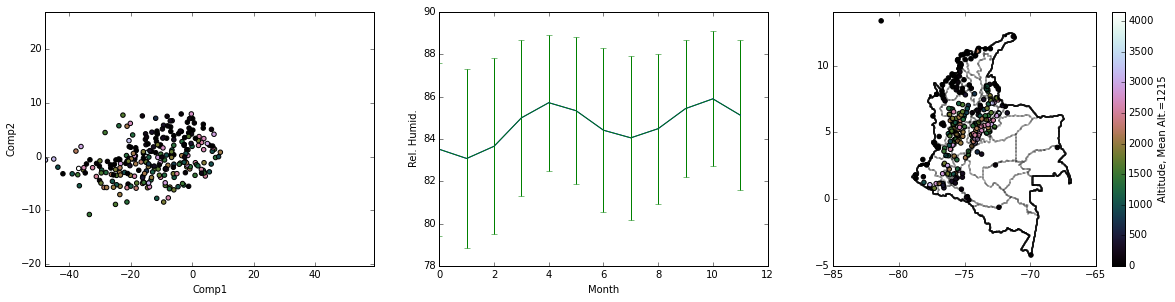

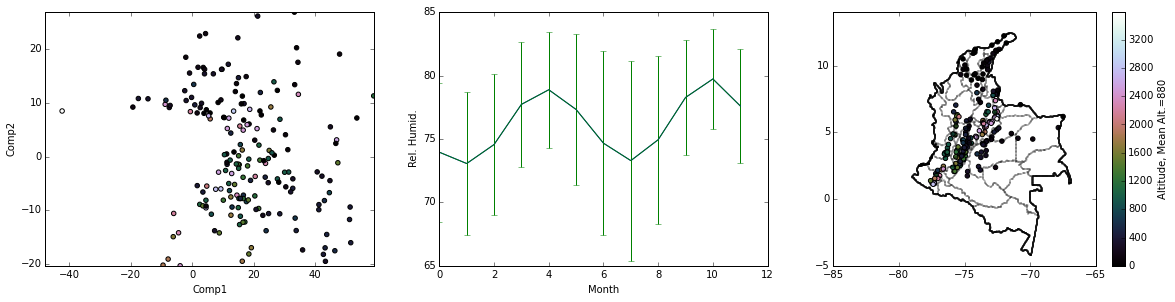

In [4]:
# Para humedad, el PCA cubre >95% de varianza
df=pd.read_csv('humedad.csv')

AH=df.as_matrix(columns=df.columns[8:20])
pca = PCA(2)  
XprojH = pca.fit_transform(AH)
print(XprojH.shape)
print pca.explained_variance_ratio_.sum(axis=0)
print pca.explained_variance_ratio_

# para que las gráficas se vean con los mismos ejes
xmin=min(XprojH[:, 0])
xmax=max(XprojH[:, 0])
ymin=min(XprojH[:, 1])
ymax=max(XprojH[:, 1])

# conversión de formato LATLON
latH=np.zeros(len(df.LATITUD))
lonH=np.zeros(len(df.LATITUD))
codeH=np.zeros(len(df.LATITUD))
altH=np.zeros(len(df.LATITUD))
for i in range(len(df.LATITUD)):
    latH[i]=conversion(df.LATITUD[i])
    lonH[i]=conversion(df.LONGITUD[i])
    codeH[i]=df.CODIGO[i]
    altH[i]=df.ELEV[i]
    
# Mixtura gaussiana para kcomp clusters
kcomp=2
gmm = GMM(kcomp, covariance_type='full', random_state=0)
gmm.fit(XprojH)
print gmm.bic(XprojH)
cluster_labelH = gmm.predict(XprojH)


# Se hace una gráfica para cada cluster
for kk in range(kcomp):
    D=np.zeros([sum(cluster_labelH==kk),2])
    B=np.zeros([sum(cluster_labelH==kk),12])
    LAT=np.zeros([sum(cluster_labelH==kk)])
    LON=np.zeros([sum(cluster_labelH==kk)])
    ALTH=np.zeros([sum(cluster_labelH==kk)])
    i=0
    for k in range(len(cluster_labelH)):
        if cluster_labelH[k]==kk:
            B[i]=AH[k]
            D[i]=XprojH[k]
            LAT[i]=latH[k]
            LON[i]=lonH[k]
            ALTH[i]=df.ELEV[k]
            i=i+1
    print "Number of stations in cluster %i is %i" %(kk,i)
    plt.figure(figsize=(20,5*kcomp))
    ii=0

#
    plt.subplot(kcomp, 3, ii+1)
    plt.scatter(D[:, 0], D[:, 1],c=ALTH,cmap='cubehelix')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('Comp1')
    plt.ylabel('Comp2')

    xx=np.arange(12)
    plt.subplot(kcomp, 3, ii+2)
    plt.plot(B.mean(axis=0))
    plt.errorbar(xx,B.mean(axis=0),yerr=B.std(axis=0))
    plt.xlabel('Month')
    plt.ylabel('Rel. Humid.')

    plt.subplot(kcomp, 3, ii+3)
    plt.scatter(-LON,-LAT,c=ALTH,cmap='cubehelix')
    plt.colorbar(label='Altitude, Mean Alt.=%i' % ALTH.mean())
    plt.scatter(colvec[:,0],colvec[:,1],s=0.01)
    plt.xlim(-85,-65)
    plt.ylim(-5,14)
    ii=ii+3

38


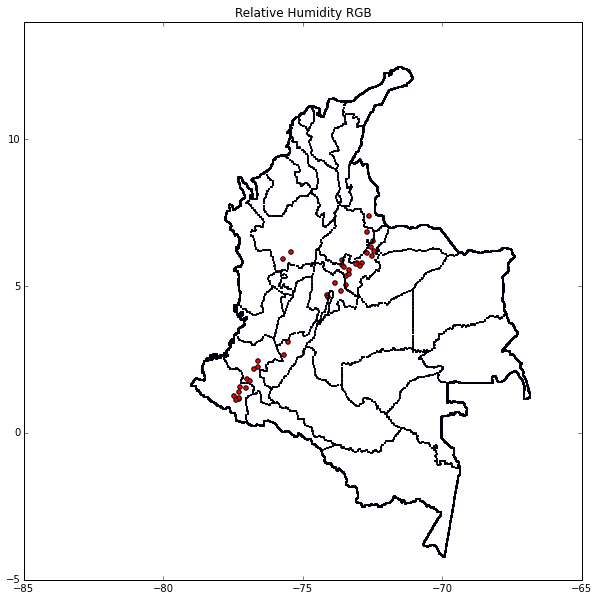

In [5]:
# Esto es para graficarlos todos en una misma gráfica de LATLON. Ahora LAT y LON son arrays
LATH=np.zeros([len(cluster_labelH),kcomp])
LONH=np.zeros([len(cluster_labelH),kcomp])
ALTH=np.zeros([len(cluster_labelH),kcomp])
CODH=np.zeros([len(cluster_labelH),kcomp])
for kk in range(kcomp):
    i=0
    for k in range(len(df)):
        if cluster_labelH[k]==kk:
            LATH[i,kk]=latH[k]
            LONH[i,kk]=lonH[k]
            ALTH[i,kk]=df.ELEV[k]
            CODH[i,kk]=df.CODIGO[k]
            i=i+1
# Los puntos rojos son el segundo cluster, el más interesante para nosotros
# Los siguientes importantes son los verdes (cuarto cluster)
plt.figure(figsize=(10,10))
filter1=ALTH[:,1]>1500
filter0=ALTH[:,0]>1500
plt.scatter(-LONH[:,1][filter1],-LATH[:,1][filter1],c='r')
plt.scatter(colvec[:,0],colvec[:,1],s=1)
#plt.scatter(-LONH[:,0][filter0],-LATH[:,0][filter0],c='g')
plt.xlim(-85,-65)
plt.ylim(-5,14)
plt.title("Relative Humidity RGB")
print filter1.sum()

(2046, 12)
(2046, 3)
0.959578491041
[ 0.78211583  0.13516064  0.04230202]
Number of stations in cluster 0 is 67
Number of stations in cluster 1 is 194
Number of stations in cluster 2 is 269
Number of stations in cluster 3 is 114
Number of stations in cluster 4 is 244
Number of stations in cluster 5 is 295
Number of stations in cluster 6 is 185
Number of stations in cluster 7 is 3
Number of stations in cluster 8 is 176
Number of stations in cluster 9 is 56
Number of stations in cluster 10 is 443


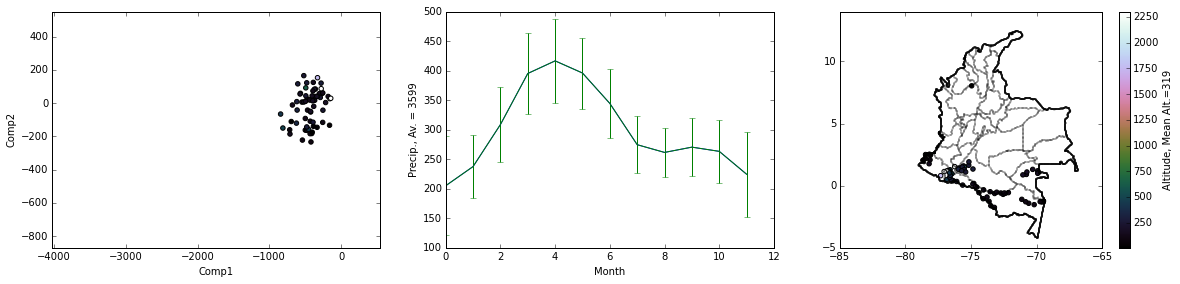

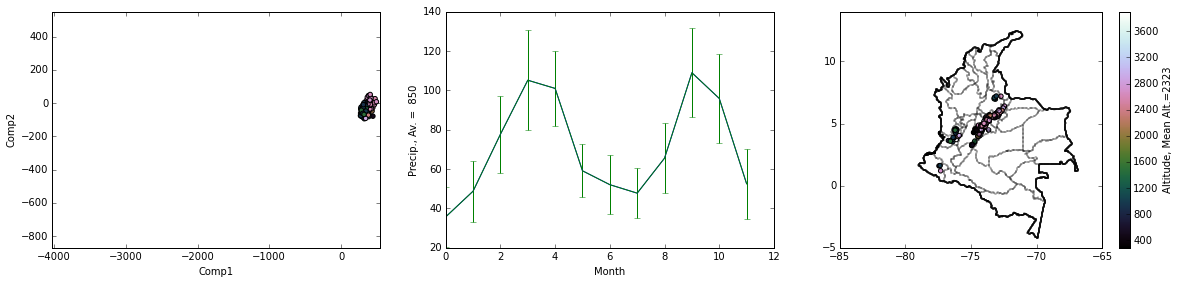

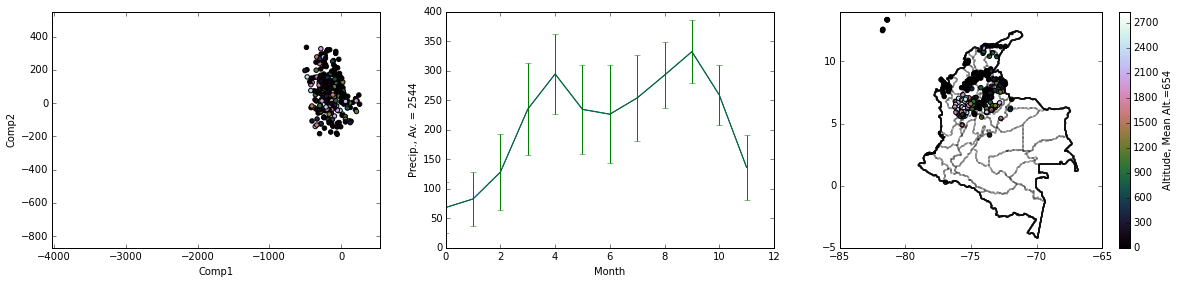

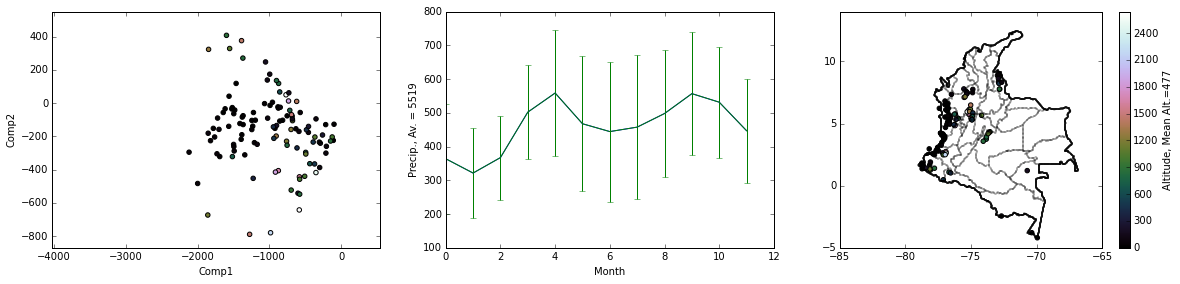

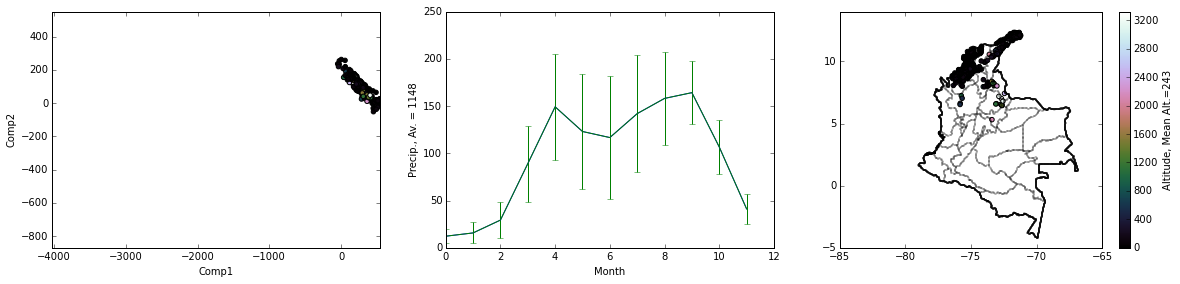

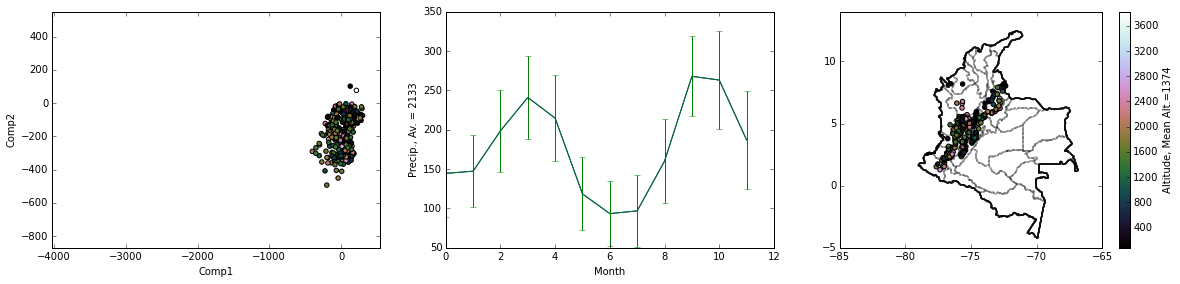

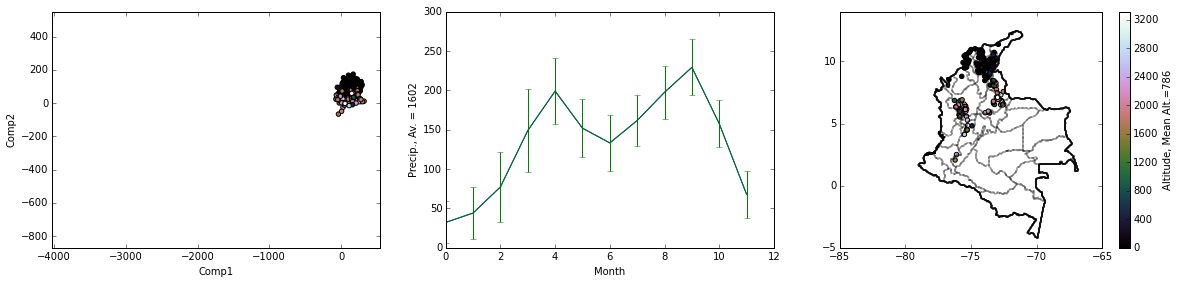

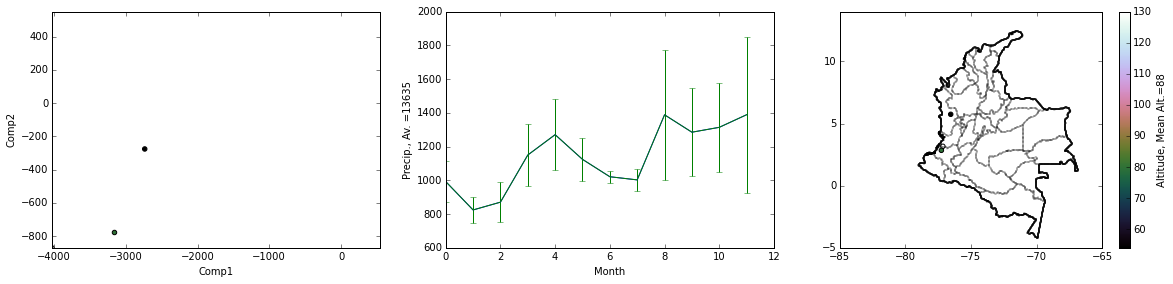

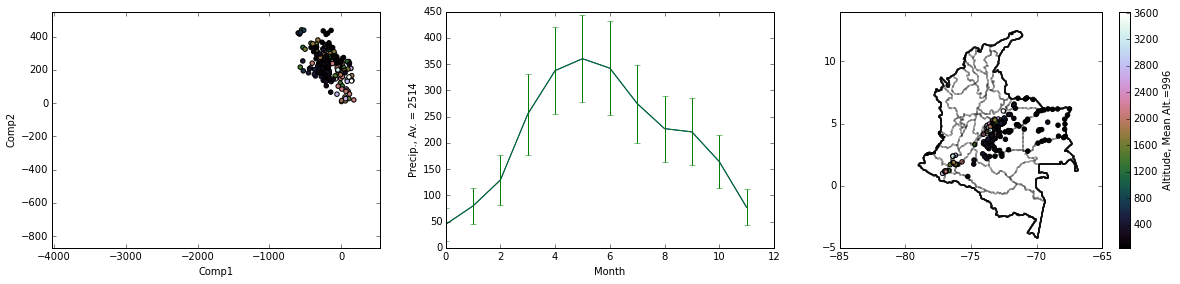

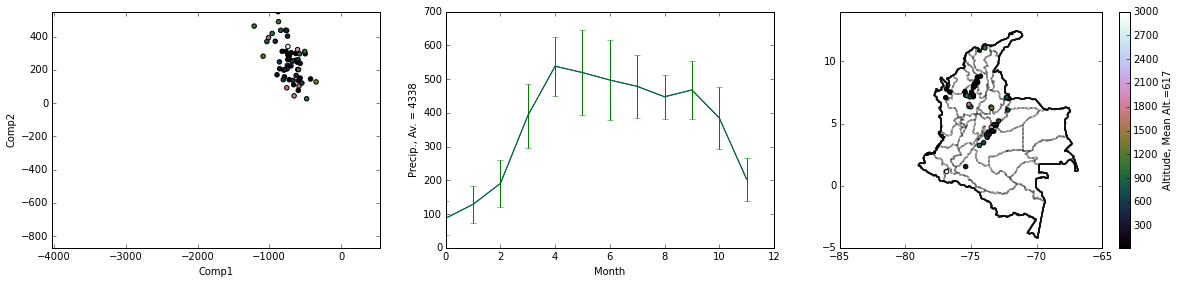

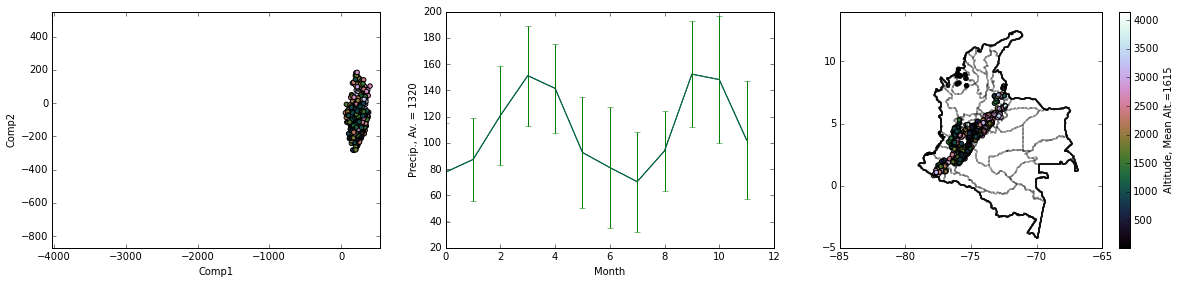

In [6]:
# ahora con lluvia, se requieren 3 componentes para cubrir >95% de varianza
df=pd.read_csv('lluvia.csv')
df.head()

# script que hace todo lo anterior, pero con lluvia, usando lluvia.csv

# Componentes principales
AL=df.as_matrix(columns=df.columns[8:20])
pca = PCA(0.95)  
XprojL = pca.fit_transform(AL)
print(AL.shape)
print(XprojL.shape)
print pca.explained_variance_ratio_.sum(axis=0)
print pca.explained_variance_ratio_
Ncomp = XprojL.shape[1]

# para que las gráficas se vean con los mismos ejes
xmin=min(XprojL[:, 0])
xmax=max(XprojL[:, 0])
ymin=min(XprojL[:, 1])
ymax=max(XprojL[:, 1])

# conversión de formato LATLON
latL=np.zeros(len(df.LATITUD))
lonL=np.zeros(len(df.LATITUD))
codeL=np.zeros(len(df.LATITUD))
altL=np.zeros(len(df.LATITUD))
for i in range(len(df.LATITUD)):
    latL[i]=conversion(df.LATITUD[i])
    lonL[i]=conversion(df.LONGITUD[i])
    codeL[i]=df.CODIGO[i]
    altL[i]=df.ELEV[i]
    
# Mixtura gaussiana para kcomp clusters (4)
kcomp=11
gmm = GMM(kcomp, covariance_type='full', random_state=0)
gmm.fit(XprojL)
cluster_labelL = gmm.predict(XprojL)


# Se hace una gráfica para cada cluster
for kk in range(kcomp):
    D=np.zeros([sum(cluster_labelL==kk),Ncomp])
    B=np.zeros([sum(cluster_labelL==kk),12])
    LAT=np.zeros([sum(cluster_labelL==kk)])
    LON=np.zeros([sum(cluster_labelL==kk)])
    ALTL=np.zeros([sum(cluster_labelL==kk)])
    i=0
    for k in range(len(df)):
        if cluster_labelL[k]==kk:
            B[i]=AL[k]
            D[i]=XprojL[k]
            LAT[i]=latL[k]
            LON[i]=lonL[k]
            ALTL[i]=df.ELEV[k]
            i=i+1
    print "Number of stations in cluster %i is %i" %(kk,i)
    plt.figure(figsize=(20,5*kcomp))
    ii=0

#
    plt.subplot(kcomp, 3, ii+1)
    plt.scatter(D[:, 0], D[:, 1],c=ALTL,cmap='cubehelix')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('Comp1')
    plt.ylabel('Comp2')

    xx=np.arange(12)
    plt.subplot(kcomp, 3, ii+2)
    plt.plot(B.mean(axis=0))
    plt.errorbar(xx,B.mean(axis=0),yerr=B.std(axis=0))
    plt.xlabel('Month')
    plt.ylabel('Precip., Av. =%5.f' % B.mean(axis=0).sum())

    plt.subplot(kcomp, 3, ii+3)
    plt.scatter(-LON,-LAT,c=ALTL,cmap='cubehelix')
    plt.colorbar(label='Altitude, Mean Alt.=%i' % ALTL.mean())
    plt.scatter(colvec[:,0],colvec[:,1],s=0.01)
    plt.xlim(-85,-65)
    plt.ylim(-5,14)
    ii=ii+3
    

445


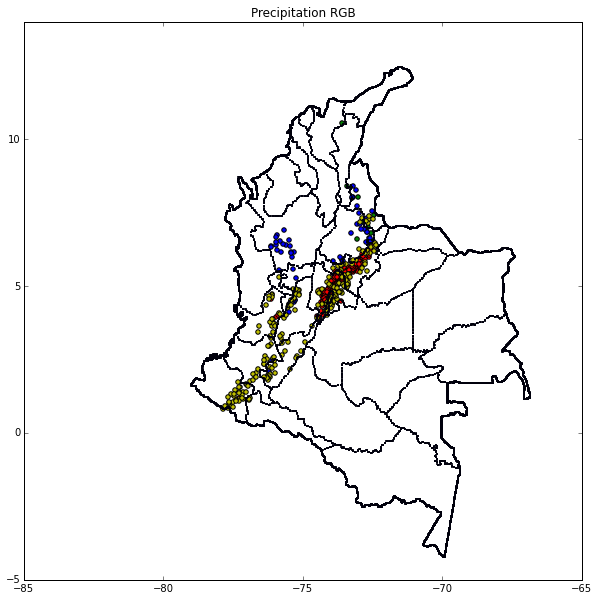

In [7]:
# Esto es para graficarlos todos en una misma gráfica de LATLON. Ahora LAT y LON son arrays
LATL=np.zeros([len(cluster_labelL),kcomp])
LONL=np.zeros([len(cluster_labelL),kcomp])
ALTL=np.zeros([len(cluster_labelL),kcomp])
CODL=np.zeros([len(cluster_labelL),kcomp])
for kk in range(kcomp):
    i=0
    for k in range(len(df)):
        if cluster_labelL[k]==kk:
            LATL[i,kk]=latL[k]
            LONL[i,kk]=lonL[k]
            ALTL[i,kk]=df.ELEV[k]
            CODL[i,kk]=df.CODIGO[k]
            i=i+1
# Graficamos 3 componentes al tiempo. Los puntos rojos son el primer cluster, el más interesante para nosotros
# Los siguientes importantes son el segundo cluster (verdes)
plt.figure(figsize=(10,10))
filter1=ALTL[:,1]>1500
filter4=ALTL[:,4]>1500
filter6=ALTL[:,6]>1500
filter10=ALTL[:,10]>1500
plt.scatter(-LONL[:,1][filter1],-LATL[:,1][filter1],c='r')
plt.scatter(-LONL[:,4][filter4],-LATL[:,4][filter4],c='g')
plt.scatter(-LONL[:,6][filter6],-LATL[:,6][filter6],c='b')
plt.scatter(-LONL[:,10][filter10],-LATL[:,10][filter10],c='y')
plt.scatter(colvec[:,0],colvec[:,1],s=1)

# Esta no porque pa que
#plt.scatter(-LON[:,3],-LAT[:,3],c='y')
plt.xlim(-85,-65)
plt.ylim(-5,14)
plt.title("Precipitation RGB")
print filter1.sum()+filter4.sum()+filter6.sum()+filter10.sum()

(2002, 12)
(2002, 3)
0.963298585519
[ 0.77041413  0.16628419  0.02660027]
Number of stations in cluster 0 is 359
Number of stations in cluster 1 is 244
Number of stations in cluster 2 is 444
Number of stations in cluster 3 is 348
Number of stations in cluster 4 is 278
Number of stations in cluster 5 is 329


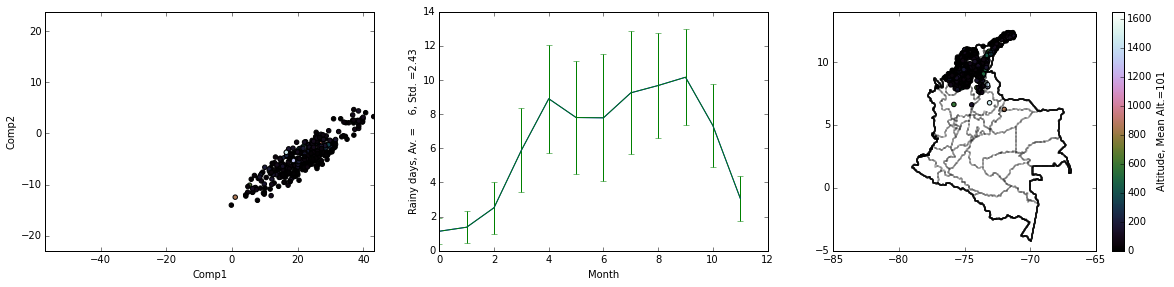

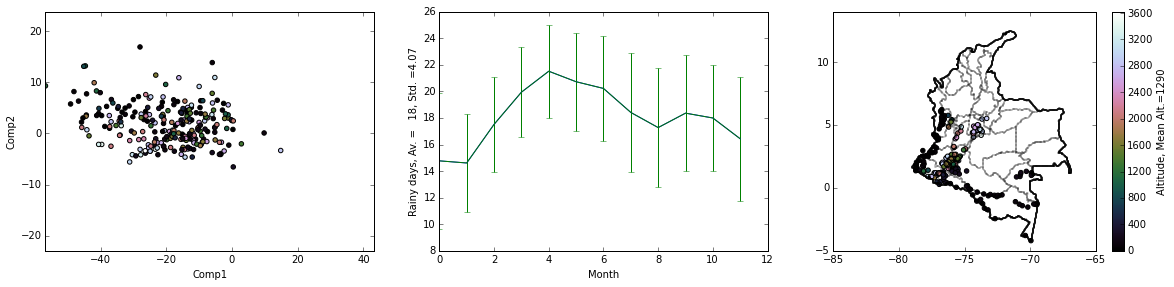

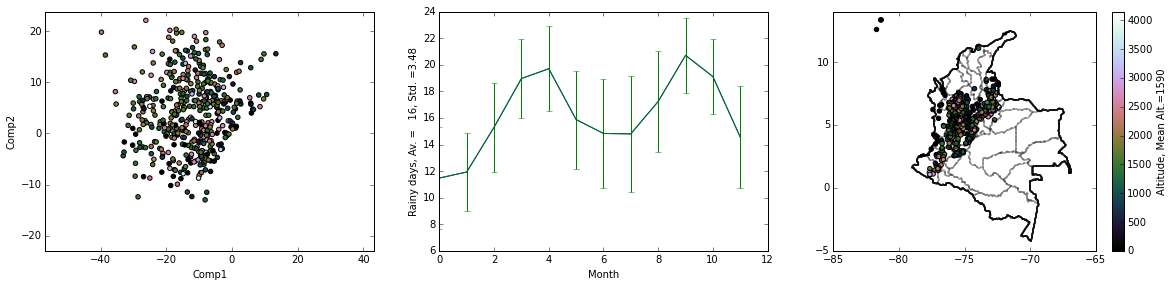

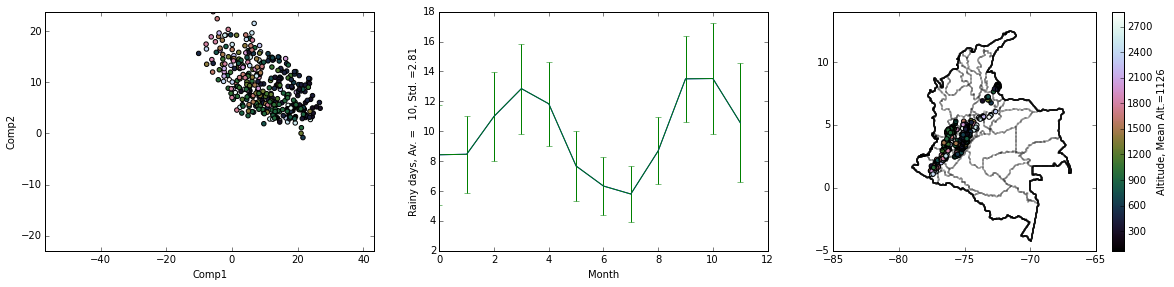

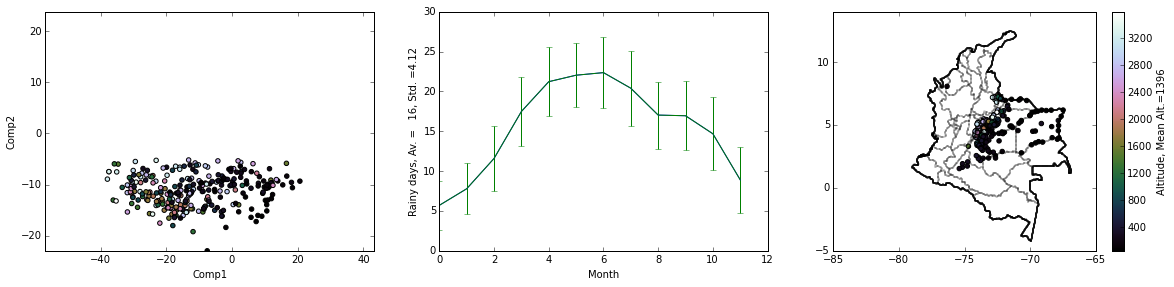

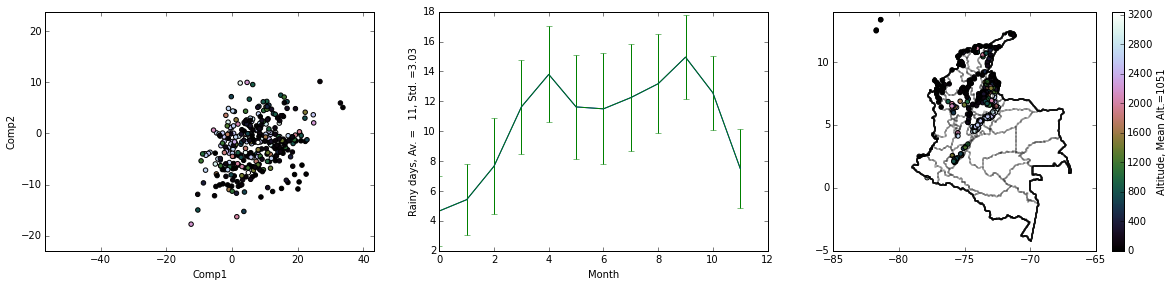

In [8]:
# ahora con días con lluvia, también toca con tres componentes
df=pd.read_csv('diaslluvia.csv')

#datos crudos mes a mes por estacion - días con lluvia de diaslluvia.csv
#AB=AD[np.isfinite(AD).prod(axis=1).astype(bool),:]
AD=df.as_matrix(columns=df.columns[8:20])
pca = PCA(0.95)  
XprojD = pca.fit_transform(AD)
print(AD.shape)
print(XprojD.shape)
print pca.explained_variance_ratio_.sum(axis=0)
print pca.explained_variance_ratio_
Ncomp = XprojD.shape[1]

# para que las gráficas se vean con los mismos ejes
xmin=min(XprojD[:, 0])
xmax=max(XprojD[:, 0])
ymin=min(XprojD[:, 1])
ymax=max(XprojD[:, 1])

# conversión de formato LATLON
latD=np.zeros(len(df.LATITUD))
lonD=np.zeros(len(df.LATITUD))
codeD=np.zeros(len(df.LATITUD))
altD=np.zeros(len(df.LATITUD))
for i in range(len(df.LATITUD)):
    latD[i]=conversion(df.LATITUD[i])
    lonD[i]=conversion(df.LONGITUD[i])
    codeD[i]=df.CODIGO[i]    
    altD[i]=df.ELEV[i]
# Mixtura gaussiana para kcomp clusters
kcomp=6
gmm = GMM(kcomp, covariance_type='full', random_state=0)
gmm.fit(XprojD)
cluster_labelD = gmm.predict(XprojD)
#df['Cluster1'] = cluster_label

# Se hace una gráfica para cada cluster
for kk in range(kcomp):
    D=np.zeros([sum(cluster_labelD==kk),Ncomp])
    B=np.zeros([sum(cluster_labelD==kk),12])
    LAT=np.zeros([sum(cluster_labelD==kk)])
    LON=np.zeros([sum(cluster_labelD==kk)])
    ALT=np.zeros([sum(cluster_labelD==kk)])
    i=0
    for k in range(len(cluster_labelD)):
        if cluster_labelD[k]==kk:
            B[i]=AD[k]
            D[i]=XprojD[k]
            LAT[i]=latD[k]
            LON[i]=lonD[k]
            ALT[i]=df.ELEV[k]
            i=i+1
    print "Number of stations in cluster %i is %i" %(kk,i)
    plt.figure(figsize=(20,5*kcomp))
    ii=0

#
    plt.subplot(kcomp, 3, ii+1)
    plt.scatter(D[:, 0], D[:, 1],c=ALT,cmap='cubehelix')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('Comp1')
    plt.ylabel('Comp2')

    xx=np.arange(12)
    plt.subplot(kcomp, 3, ii+2)
    plt.plot(B.mean(axis=0))
    plt.errorbar(xx,B.mean(axis=0),yerr=B.std(axis=0))
    plt.xlabel('Month')
    plt.ylabel('Rainy days, Av. =%5.f, Std. =%2.2f' % (B.mean(axis=0).mean(),B.std(axis=0).mean())  )

    plt.subplot(kcomp, 3, ii+3)
    plt.scatter(-LON,-LAT,c=ALT,cmap='cubehelix')
    plt.colorbar(label='Altitude, Mean Alt.=%i' % ALT.mean())
    plt.scatter(colvec[:,0],colvec[:,1],s=0.01)
    plt.xlim(-85,-65)
    plt.ylim(-5,14)
    ii=ii+3
    

199


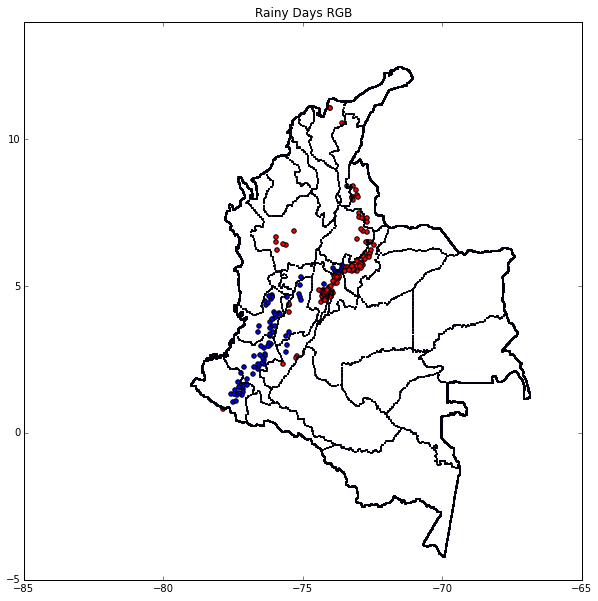

In [9]:
# Esto es para graficarlos todos en una misma gráfica de LATLON. Ahora LAT y LON son arrays
LATD=np.zeros([len(cluster_labelD),kcomp])
LOND=np.zeros([len(cluster_labelD),kcomp])
ALTD=np.zeros([len(cluster_labelD),kcomp])
CODD=np.zeros([len(cluster_labelD),kcomp])

for kk in range(kcomp):
    i=0
    for k in range(len(cluster_labelD)):
        if cluster_labelD[k]==kk:
            LATD[i,kk]=latD[k]
            LOND[i,kk]=lonD[k]
            ALTD[i,kk]=df.ELEV[k]
            CODD[i,kk]=df.CODIGO[k]
            i=i+1
# Graficamos 3 componentes al tiempo. Los puntos rojos son el primer cluster, el más interesante para nosotros
# El tercero también es interesante
# Lo otro que falta es hacer un clustering por LONLAT y altura sobre las estaciones que tengan las condiciones ideales
plt.figure(figsize=(10,10))

filter0=ALTD[:,0]>1500
filter3=ALTD[:,3]>1500
filter5=ALTD[:,5]>1500
plt.scatter(-LOND[:,0][filter0],-LATD[:,0][filter0],c='g')
plt.scatter(-LOND[:,3][filter3],-LATD[:,3][filter3],c='b')
plt.scatter(-LOND[:,5][filter5],-LATD[:,5][filter5],c='r')
plt.scatter(colvec[:,0],colvec[:,1],s=1)

# Esta no porque pa que
#plt.scatter(-LON[:,3],-LAT[:,3],c='y')
plt.xlim(-85,-65)
plt.ylim(-5,14)
plt.title('Rainy Days RGB')
# Hay que cambiar el orden, primero es 2, segundo es 0
print filter0.sum()+filter3.sum()+filter5.sum()

(336, 12)
(336, 3)
0.968881031972
[ 0.8163693   0.11928973  0.03322201]
3982.44755121
Number of stations in cluster 0 is 121
Number of stations in cluster 1 is 46
Number of stations in cluster 2 is 63
Number of stations in cluster 3 is 43
Number of stations in cluster 4 is 63


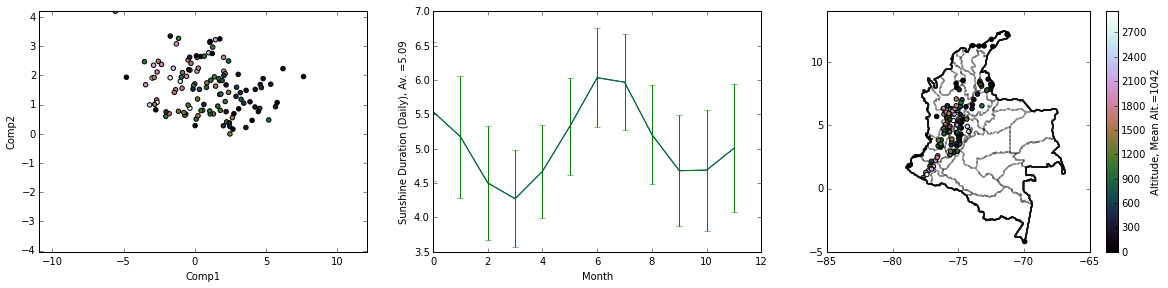

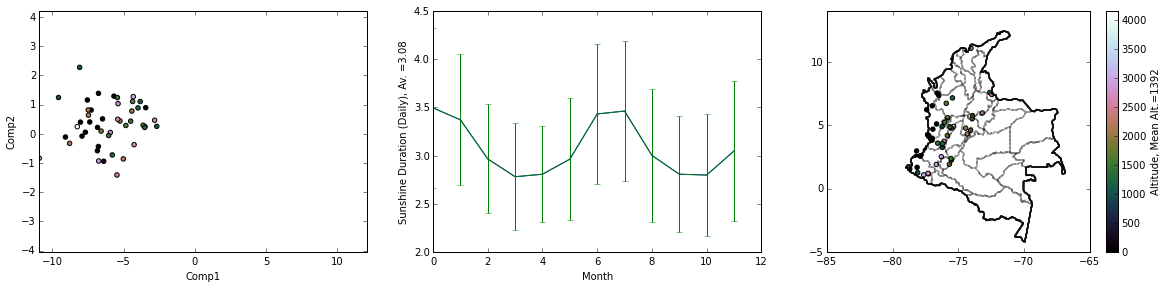

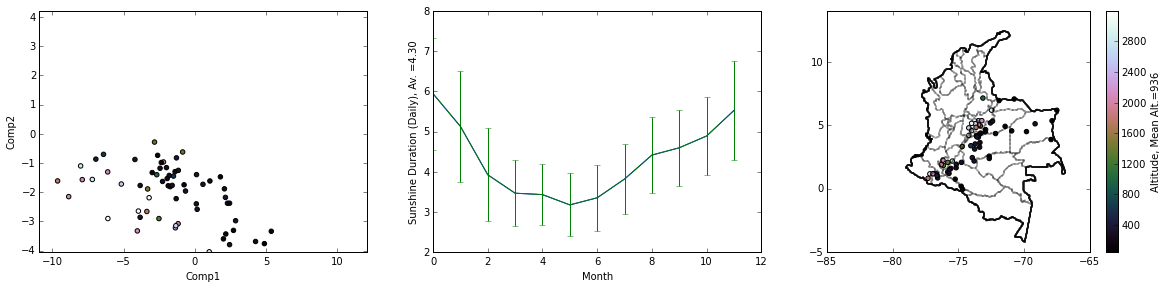

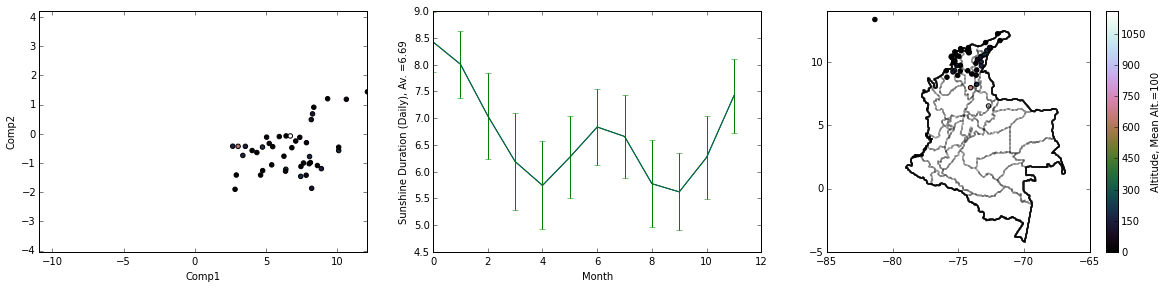

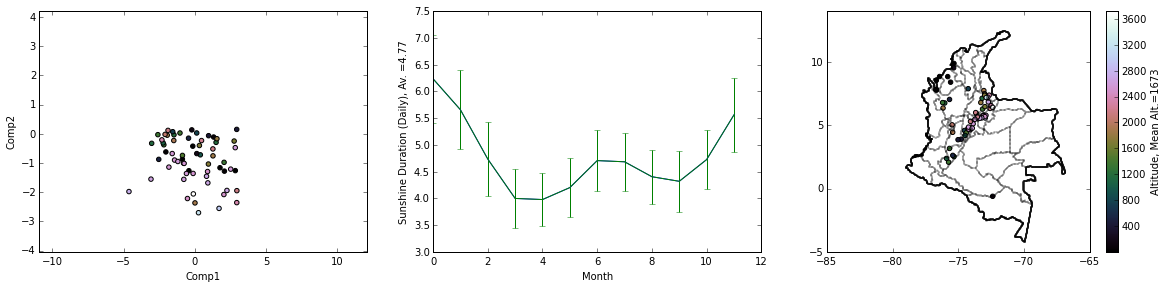

In [10]:
# ahora con brillo solar
df=pd.read_csv('brillo.csv')

#datos crudos mes a mes por estacion - brillo solar de brillo.csv
AB=df.as_matrix(columns=df.columns[8:20])
pca = PCA(0.95)  
XprojB = pca.fit_transform(AB)
print(AB.shape)
print(XprojB.shape)
print pca.explained_variance_ratio_.sum(axis=0)
print pca.explained_variance_ratio_
Ncomp = XprojB.shape[1]


# para que las gráficas se vean con los mismos ejes
xmin=min(XprojB[:, 0])
xmax=max(XprojB[:, 0])
ymin=min(XprojB[:, 1])
ymax=max(XprojB[:, 1])

# conversión de formato LATLON
latB=np.zeros(len(df.LATITUD))
lonB=np.zeros(len(df.LATITUD))
codeB=np.zeros(len(df.LATITUD))
altB=np.zeros(len(df.LATITUD))
for i in range(len(df.LATITUD)):
    latB[i]=conversion(df.LATITUD[i])
    lonB[i]=conversion(df.LONGITUD[i])
    codeB[i]=df.CODIGO[i]    
    altB[i]=df.ELEV[i]
# Mixtura gaussiana para kcomp clusters
kcomp=5
gmm = GMM(kcomp, covariance_type='tied', random_state=0)
gmm.fit(XprojB)
print gmm.bic(XprojB)
cluster_labelB = gmm.predict(XprojB)
#df['Cluster1'] = cluster_label

# Se hace una gráfica para cada cluster
for kk in range(kcomp):
    D=np.zeros([sum(cluster_labelB==kk),Ncomp])
    B=np.zeros([sum(cluster_labelB==kk),12])
    LAT=np.zeros([sum(cluster_labelB==kk)])
    LON=np.zeros([sum(cluster_labelB==kk)])
    ALT=np.zeros([sum(cluster_labelB==kk)])
    i=0
    for k in range(len(cluster_labelB)):
        if cluster_labelB[k]==kk:
            B[i]=AB[k]
            D[i]=XprojB[k]
            LAT[i]=latB[k]
            LON[i]=lonB[k]
            ALT[i]=df.ELEV[k]
            i=i+1
    print "Number of stations in cluster %i is %i" %(kk,i)
    plt.figure(figsize=(20,5*kcomp))
    ii=0

#
    plt.subplot(kcomp, 3, ii+1)
    plt.scatter(D[:, 0], D[:, 1],c=ALT,cmap='cubehelix')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('Comp1')
    plt.ylabel('Comp2')

    xx=np.arange(12)
    plt.subplot(kcomp, 3, ii+2)
    plt.plot(B.mean(axis=0))
    plt.errorbar(xx,B.mean(axis=0),yerr=B.std(axis=0))
    plt.xlabel('Month')
    plt.ylabel('Sunshine Duration (Daily), Av. =%.2f' % B.mean(axis=0).mean())

    plt.subplot(kcomp, 3, ii+3)
    plt.scatter(-LON,-LAT,c=ALT,cmap='cubehelix')
    plt.colorbar(label='Altitude, Mean Alt.=%i' % ALT.mean())
    plt.scatter(colvec[:,0],colvec[:,1],s=0.01)
    plt.xlim(-85,-65)
    plt.ylim(-5,14)
    ii=ii+3
    

69


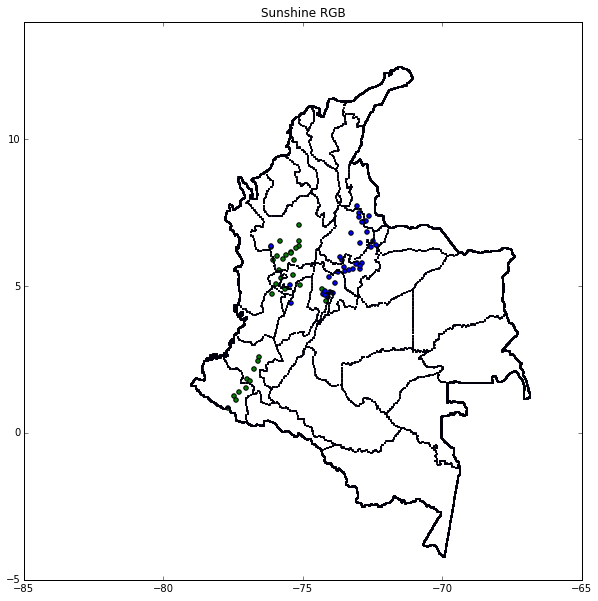

In [11]:
# Esto es para graficarlos todos en una misma gráfica de LATLON. Ahora LAT y LON son arrays
LATB=np.zeros([len(cluster_labelB),kcomp])
LONB=np.zeros([len(cluster_labelB),kcomp])
ALTB=np.zeros([len(cluster_labelB),kcomp])
CODB=np.zeros([len(cluster_labelB),kcomp])
for kk in range(kcomp):
    i=0
    for k in range(len(cluster_labelB)):
        if cluster_labelB[k]==kk:
            LATB[i,kk]=latB[k]
            LONB[i,kk]=lonB[k]
            ALTB[i,kk]=df.ELEV[k]
            CODB[i,kk]=df.CODIGO[k]
            i=i+1
# Graficamos 3 componentes al tiempo. Los puntos rojos son el segundo cluster, el más interesante para nosotros
# El cuarto también es interesante
# Lo otro que falta es hacer un clustering por LONLAT y altura sobre las estaciones que tengan las condiciones ideales
plt.figure(figsize=(10,10))
filter3=ALTB[:,3]>1500
filter4=ALTB[:,4]>1500

filter0=ALTB[:,0]>1500
plt.scatter(-LONB[:,0][filter0],-LATB[:,0][filter0],c='g')
#plt.scatter(-LONB[:,1],-LATB[:,1],c='y')
#plt.scatter(-LONB[:,3],-LATB[:,3],c='b')
# Esta no porque pa que
plt.scatter(-LONB[:,3][filter3],-LATB[:,3][filter3],c='r')
plt.scatter(-LONB[:,4][filter4],-LATB[:,4][filter4],c='b')
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.xlim(-85,-65)
plt.ylim(-5,14)
plt.title('Sunshine RGB')
# principal: 2 secundario 0
print filter0.sum()+filter3.sum()+filter4.sum()

(-5, 14)

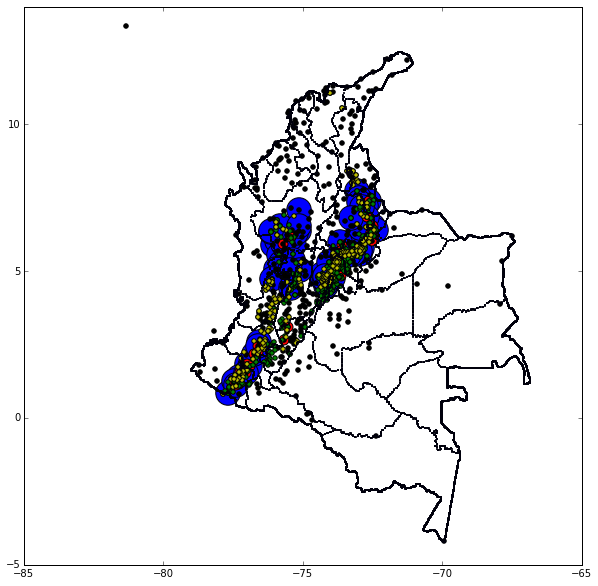

In [12]:
#Aplicamos el filtro de altura > 1500 msnm para cada grupo de interes para cada variable

plt.figure(figsize=(10,10))
filter3=ALTB[:,3]>1500
filter4=ALTB[:,4]>1500
filter0=ALTB[:,0]>1500
plt.scatter(-LONB[:,0][filter0],-LATB[:,0][filter0],c='b',s=600)
plt.scatter(-LONB[:,3][filter3],-LATB[:,3][filter3],c='b',s=600)
plt.scatter(-LONB[:,4][filter4],-LATB[:,4][filter4],c='b',s=600)

filter1=ALTH[:,1]>1500
plt.scatter(-LONH[:,1][filter1],-LATH[:,1][filter1],c='r',s=100)
plt.scatter(-LONH[:,1],-LATH[:,1],c='k')
plt.scatter(-LONH[:,0],-LATH[:,0],c='k')

filter1=ALTL[:,1]>1500
filter4=ALTL[:,4]>1500
filter6=ALTL[:,6]>1500
filter10=ALTL[:,10]>1500
plt.scatter(-LONL[:,1][filter1],-LATL[:,1][filter1],c='g')
plt.scatter(-LONL[:,4][filter4],-LATL[:,4][filter4],c='g')
plt.scatter(-LONL[:,6][filter6],-LATL[:,6][filter6],c='g')
plt.scatter(-LONL[:,10][filter10],-LATL[:,10][filter10],c='g')

filter0=ALTD[:,0]>1500
filter3=ALTD[:,3]>1500
filter5=ALTD[:,5]>1500
plt.scatter(-LOND[:,0][filter0],-LATD[:,0][filter0],c='y')
plt.scatter(-LOND[:,3][filter3],-LATD[:,3][filter3],c='y')
plt.scatter(-LOND[:,5][filter5],-LATD[:,5][filter5],c='y')
plt.scatter(colvec[:,0],colvec[:,1],s=1)


plt.xlim(-85,-65)
plt.ylim(-5,14)

In [13]:
# funcion que une los grupos de interes para cada variable, segun la clasificacion del modelo de mixtura gaussiana
# genera un arreglo con los datos "extraidos", p.ej. de todos los datos de precipitacion saco solo los que me interesan
# PP es una lista con los grupos que me interesan para cada variable
def stitch(PP,ALT,LON,LAT,COD):
    LN=np.array([])
    LT=np.array([])
    CD=np.array([])
    AT=np.array([])
    for i in PP:
        filter=ALT[:,i]>1500
        LN=np.hstack((LN,LON[:,i][(LON[:,i]!=0)*(filter)]))
        LT=np.hstack((LT,LAT[:,i][(LAT[:,i]!=0)*(filter)]))
        CD=np.hstack((CD,COD[:,i][(COD[:,i]!=0)*(filter)]))
        AT=np.hstack((AT,ALT[:,i][(ALT[:,i]!=0)*(filter)]))
    return np.vstack((CD,LN,LT,AT)).T

In [15]:
# Aqui usamos la funcion anterior, PP le indica a la funcion cuales grupos me interesan
PP=[0,3,4]
DATB=stitch(PP,ALTB,LONB,LATB,CODB)
PP=[1]
DATH=stitch(PP,ALTH,LONH,LATH,CODH)
PP=[1,4,6,10]
DATL=stitch(PP,ALTL,LONL,LATL,CODL)
PP=[0,3,5]
DATD=stitch(PP,ALTD,LOND,LATD,CODD)
# Se unen todas las variables en un solo arreglo, nos quedamos con 751 datos (hay repetidos)
# En este arreglo estan todos los datos que cumplen por lo menos uno de los criterios, y quedan a mas de 1500 msnm
# 0=codigo, 1,2=lonlat, 3=altura (segun la funcion stitch)
DATT=np.vstack((DATB,DATH,DATL,DATD))
np.savetxt('datos.txt',DATT)
# Luego unificamos con las estaciones que cumplen al menos un criterio

In [16]:
%%bash
awk '{print $0}' datos.txt | sort -n | uniq -c > listam.txt
rm datos.txt

In [17]:
# Contamos cuantas variables fueron medidas por estacion, se almacena en tomados (cuyo indice coincide con el indice de listam)
listam=np.loadtxt('listam.txt')
df=pd.read_csv('lluvia.csv')
tomados=np.zeros(len(listam[:,1]))
for i in range(len(listam[:,1])):
    for k in range(len(df.CODIGO)):
        if(listam[i,1]==df.CODIGO[k]):
            tomados[i]+=1
df=pd.read_csv('humedad.csv')
for i in range(len(listam[:,1])):
    for k in range(len(df.CODIGO)):
        if(listam[i,1]==df.CODIGO[k]):
            tomados[i]+=1
df=pd.read_csv('diaslluvia.csv')
for i in range(len(listam[:,1])):
    for k in range(len(df.CODIGO)):
        if(listam[i,1]==df.CODIGO[k]):
            tomados[i]+=1  
df=pd.read_csv('brillo.csv')
for i in range(len(listam[:,1])):
    for k in range(len(df.CODIGO)):
        if(listam[i,1]==df.CODIGO[k]):
            tomados[i]+=1 

In [366]:
(incog==1).sum()

3

In [18]:
probfilter=(tomados-listam[:,0]==0)
listacorta=listam[probfilter]
incog=4-listam[:,0][probfilter]

(-5, 14)

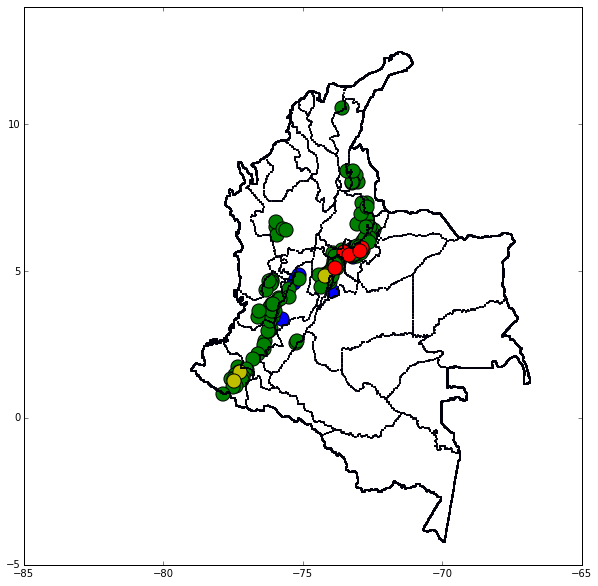

In [19]:
plt.figure(figsize=(10,10))
plt.scatter(-listacorta[:,2][incog==3.],-listacorta[:,3][incog==3.],c='b',s=200)
plt.scatter(-listacorta[:,2][incog==2.],-listacorta[:,3][incog==2.],c='g',s=200)
plt.scatter(-listacorta[:,2][incog==1.],-listacorta[:,3][incog==1.],c='y',s=200)
plt.scatter(-listacorta[:,2][incog==0.],-listacorta[:,3][incog==0.],c='r',s=200)
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.xlim(-85,-65)
plt.ylim(-5,14)

In [20]:
def genprob2(paux3,paux4):
    p3=1./4
    p4=1./16
    p33=p3*paux3
    p34=p4*paux4
    return p33+p34  
def parseprob3(i,j):
    if((i==4.)&(j==0.)):
        return genprob2(0.,1.)
    if((i==3.)&(j==1.)):
        return genprob2(0.,1./5)
    if((i==2.)&(j==2.)):
        return genprob2(0.,1./11)
    if((i==1.)&(j==3.)):
        return genprob2(0,1./15)

In [21]:
probarr3=np.zeros(len(incog))
for i in range(len(incog)):
    probarr3[i]=parseprob3(listacorta[i,0],incog[i])

(-5, 14)

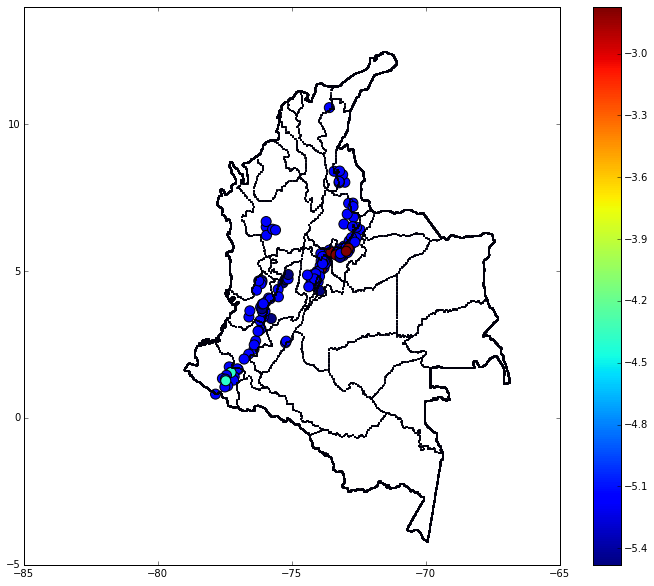

In [22]:
plt.figure(figsize=(12,10))
plt.scatter(-listacorta[:,2],-listacorta[:,3],c=np.log(probarr3),s=100)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.xlim(-85,-65)
plt.ylim(-5,14)

In [23]:
# Se unen todos los datos (los iniciales) de lonlat para ubicarlos en el mapa (hay repetidos)
CodT=np.hstack((codeB,codeH,codeL,codeD))
LonT=np.hstack((lonB,lonH,lonL,lonD))
LatT=np.hstack((latB,latH,latL,latD))
AltT=np.hstack((altB,altH,altL,altD))
np.savetxt('estaciones.txt',np.c_[CodT,LonT,LatT,AltT])
# después eliminamos repetidos y contamos cuantas variables mide cada estacion

In [24]:
%%bash
sort estaciones.txt | uniq -c > estaciones_medidas.txt
rm estaciones.txt

In [25]:
# 0=numero de variables medidas, 1=codigo de la estacion, 2,3=lonlat
EST=np.loadtxt('estaciones_medidas.txt')

(array([  9.61260495e-04,   2.02618634e-04,   2.53273292e-04,
          2.54451308e-04,   2.37959093e-04,   1.60210083e-04,
          2.36781078e-04,   8.59951178e-05,   1.29581684e-05,
          4.71206125e-06]),
 array([  1.00000000e+00,   4.15900000e+02,   8.30800000e+02,
          1.24570000e+03,   1.66060000e+03,   2.07550000e+03,
          2.49040000e+03,   2.90530000e+03,   3.32020000e+03,
          3.73510000e+03,   4.15000000e+03]),
 <a list of 10 Patch objects>)

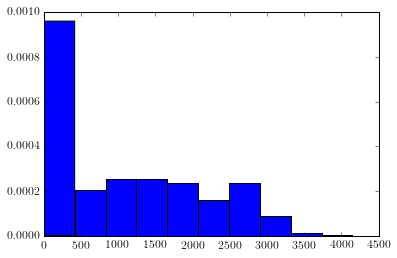

In [138]:
plt.hist(EST[:,4],normed=True)

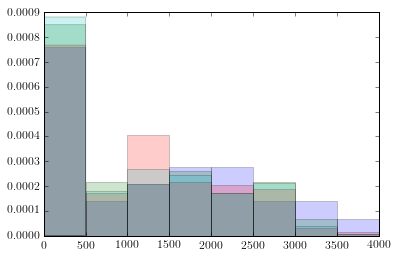

In [139]:
for i in np.arange(4)+1:
    plt.hist(EST[:,4][EST[:,0]==i],alpha=0.2,normed=True,bins=range(0,4500,500))

(array([  1.44904459e-03,   5.73248408e-04,   2.86624204e-04,
          1.27388535e-04,   2.07006369e-04,   3.18471338e-04,
          2.22929936e-04,   2.22929936e-04,   2.70700637e-04,
          2.38853503e-04,   2.38853503e-04,   1.27388535e-04,
          2.38853503e-04,   2.22929936e-04,   1.27388535e-04,
          7.96178344e-05,   1.59235669e-05,   0.00000000e+00,
          1.59235669e-05,   0.00000000e+00,   1.59235669e-05,
          0.00000000e+00]),
 array([   0,  200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000,
        2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200,
        4400]),
 <a list of 22 Patch objects>)

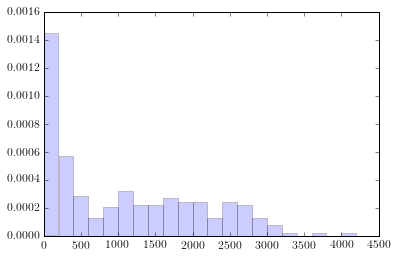

In [303]:
plt.hist(EST[:,4][EST[:,0]==4],alpha=0.2,normed=True,bins=range(0,4500,200))

In [177]:
# Author: Jake VanderPlas
# License: BSD
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
def altprob(i):
    from astroML.plotting import setup_text_plots
    setup_text_plots(fontsize=12, usetex=True)


    #gmm.means_ = np.array([[-1], [0], [3]])
    #gmm.covars_ = np.array([[1.5], [1], [0.5]]) ** 2
    #gmm.weights_ = np.array([0.3, 0.5, 0.2])

    altmin=0
    X = EST[:,4][EST[:,0]==i][:, np.newaxis]

    #------------------------------------------------------------
    # Learn the best-fit GMM models
    #  Here we'll use GMM in the standard way: the fit() method
    #  uses an Expectation-Maximization approach to find the best
    #  mixture of Gaussians for the data

    # fit models with 1-10 components
    N = np.arange(1, 11)
    models = [None for i in range(len(N))]

    for i in range(len(N)):
        models[i] = GMM(N[i]).fit(X)

    # compute the AIC and the BIC
    AIC = [m.aic(X) for m in models]
    BIC = [m.bic(X) for m in models]

    #------------------------------------------------------------
    # Plot the results

    fig = plt.figure(figsize=(20, 8))
    fig.subplots_adjust(left=0.12, right=0.97,
                        bottom=0.21, top=0.9, wspace=0.5)


    # plot 1: data + best-fit mixture
    ax = fig.add_subplot(121)
    M_best = models[np.argmin(AIC)]

    x = np.linspace(altmin,4500 , 4501)
    logprob, responsibilities = M_best.score_samples(x.reshape((-1,1)))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]


    ax.hist(X, normed=True, histtype='stepfilled', alpha=0.4,bins=range(0,4500,500))
    ax.plot(x, pdf, '-k')
    ax.plot(x, pdf_individual, '--k')
    ax.text(0.04, 0.96, "Best-fit Mixture",
            ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')
    ax.set_xlim([1500,4500])
    ax.set_ylim([0,0.0003])

    # plot 2: AIC and BIC
    ax = fig.add_subplot(122)
    ax.plot(N, AIC, '-k', label='AIC')
    ax.plot(N, BIC, '--k', label='BIC')
    ax.set_xlabel('n. components')
    ax.set_ylabel('information criterion')
    ax.legend(loc=2)
    plt.show()
    return pdf

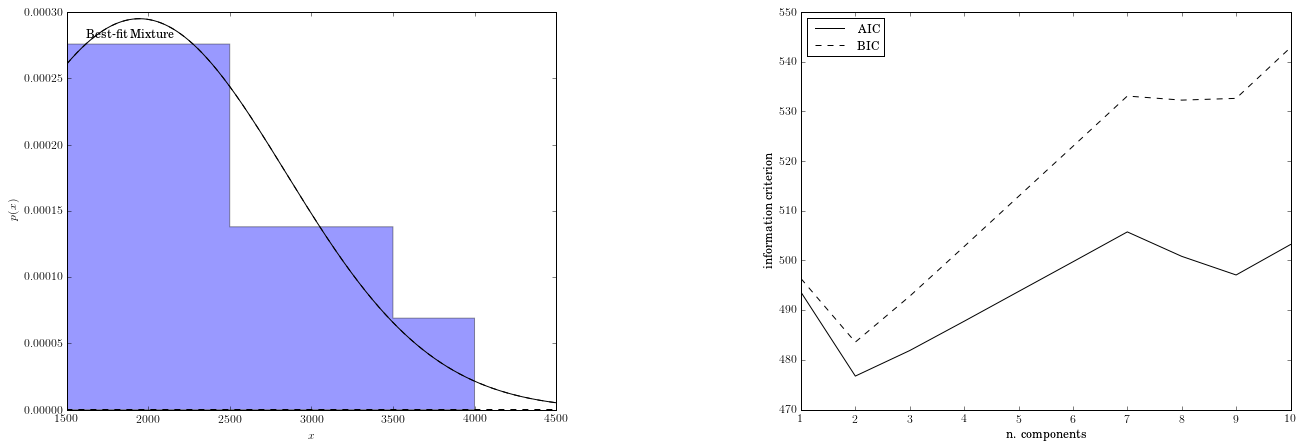

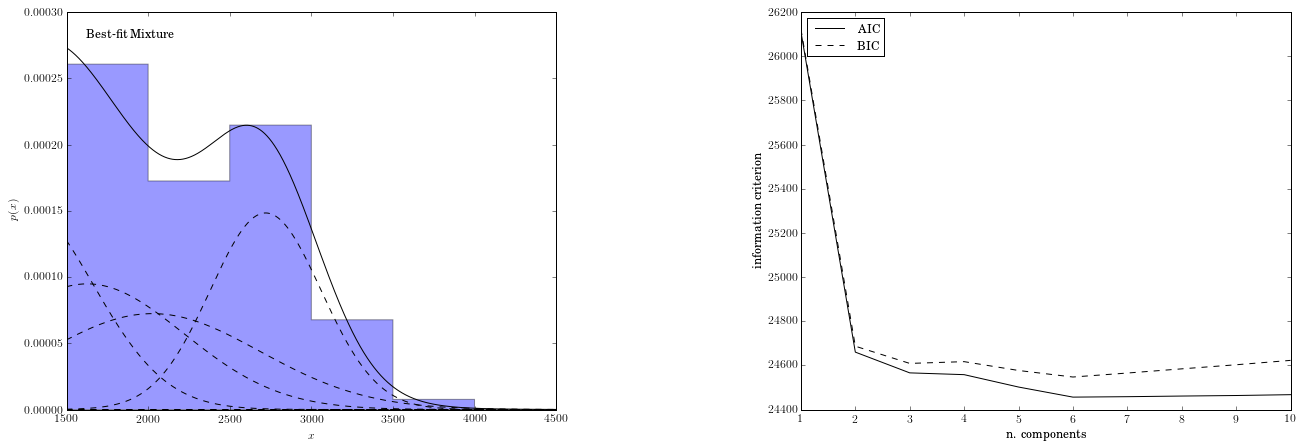

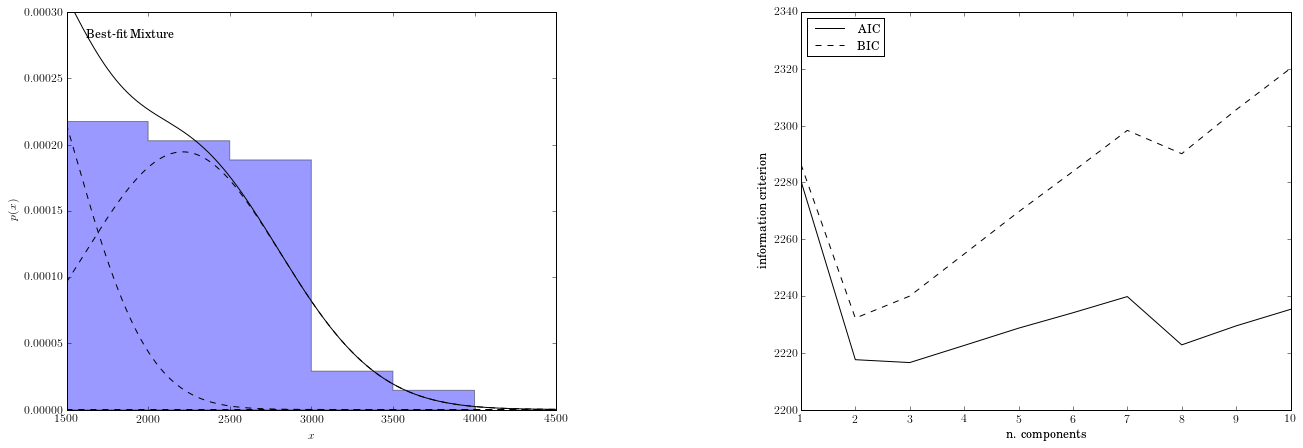

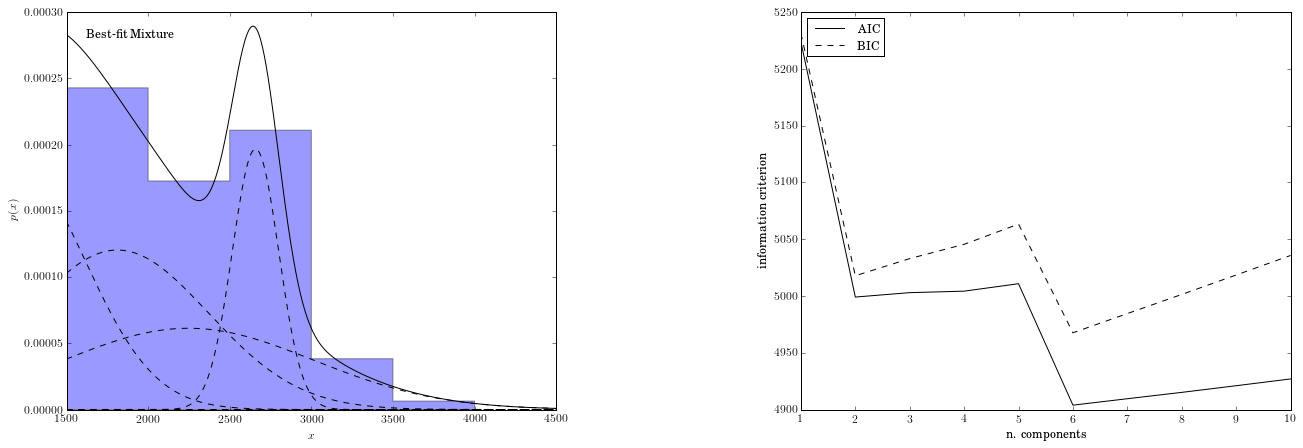

In [304]:
ap1=altprob(1);
ap2=altprob(2);
ap3=altprob(3);
ap4=altprob(4);

(0, 0.0005)

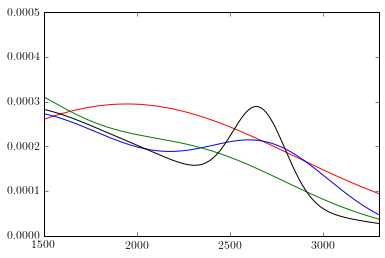

In [305]:
plt.plot(ap1,c='r')
plt.plot(ap2,c='b')
plt.plot(ap3,c='g')
plt.plot(ap4,c='k')
plt.xlim(1500,3300)
plt.ylim(0,0.0005)

In [306]:
# pesos estadísticos normalizados considerando distribución de alturas para no. de medidas y no. de criterios
aprob=np.vstack((ap1,ap2,ap3,ap4)).T
x = np.linspace(0,4500 , 4501)
normalt=1/aprob.max()/100
probarr=np.zeros(len(probarr3))
for i in range(len(probarr3)):
    pdf=aprob[:,listacorta[i,0].astype(int)-1]
    probarr[i]=probarr3[i]*165*16*np.around(1/pdf/normalt,0)[x==listacorta[i,4]][0]

In [307]:
probarr=np.around(10*probarr/probarr.min(),0)

In [308]:
#probarr=np.around(probarr/144.1,0)
# generación de lista expandida que incluye pesos enteros para cada estación
lendata=(probarr).sum().astype(int)
print lendata
wdata=(probarr).astype(int)
listaexp=np.zeros((lendata,listacorta.shape[1]))
kcount=0
for i in range(len(probarr3)):        
    for kinx in range(wdata[i]):
        listaexp[kinx+kcount,:]=listacorta[i,:]
    kcount=kcount+kinx+1 

4182


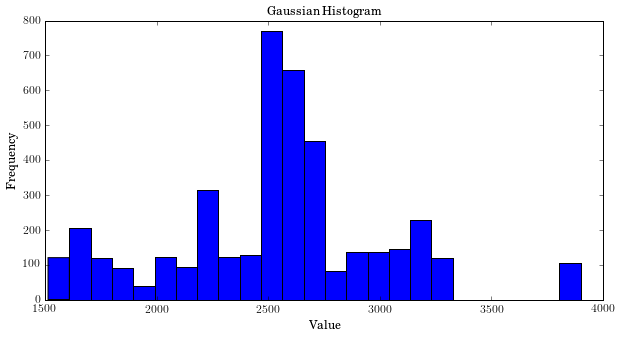

In [309]:
plt.figure(figsize=(10,5))
plt.hist(listaexp[:,4],bins=25)
plt.title("Gaussian Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")

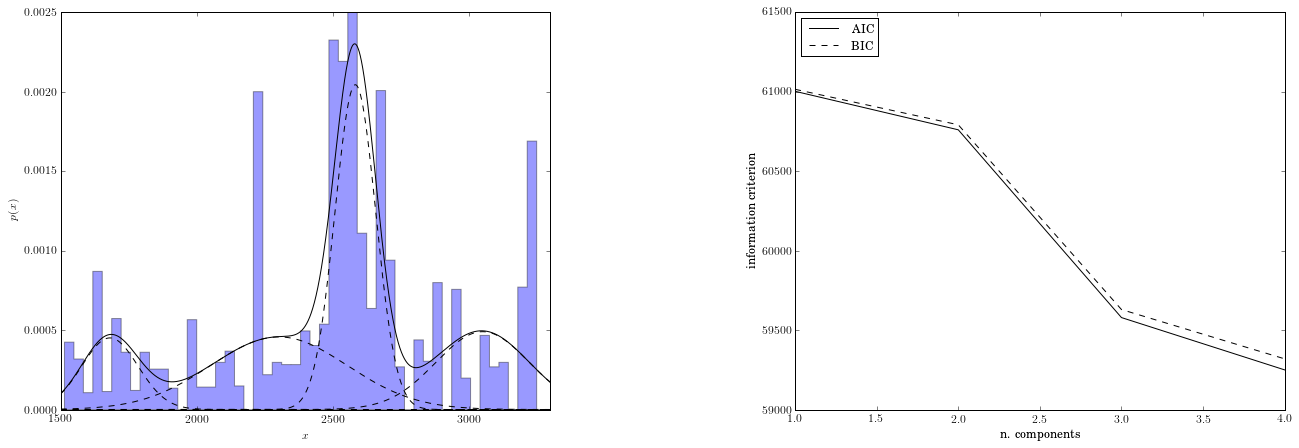

In [344]:
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)

altmin=1500
altmax=3300
X = listaexp[:,4][(listaexp[:,4]>=altmin)*(listaexp[:,4]<=altmax)][:, np.newaxis]
N = np.arange(1, 5)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GMM(N[i]).fit(X)

AIC = [m.aic(X) for m in models]

BIC = [m.bic(X) for m in models]

fig = plt.figure(figsize=(20, 8))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


ax = fig.add_subplot(121)
M_best = models[np.argmin(AIC)]

x = np.linspace(altmin,altmax , altmax+1)
logprob, responsibilities = M_best.score_samples(x.reshape((-1,1)))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]


ax.hist(X, 50, normed=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
ax.set_xlim([altmin,altmax])
#ax.set_ylim([0,0.0003])
ax = fig.add_subplot(122)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)
plt.show()

In [331]:
cluster_label_alt=M_best.predict(X)[:, np.newaxis]
filter=(listaexp[:,4]>=altmin)*(listaexp[:,4]<=altmax)
listastacked=np.hstack((listaexp[filter],cluster_label_alt))
np.savetxt('lisstck.txt',listastacked)

In [332]:
np.unique(cluster_label_alt)

array([0, 1, 2, 3])

In [333]:
%%bash
uniq -c lisstck.txt > listcomp.txt
rm lisstck.txt

<matplotlib.colorbar.Colorbar instance at 0x7f05aaa14950>

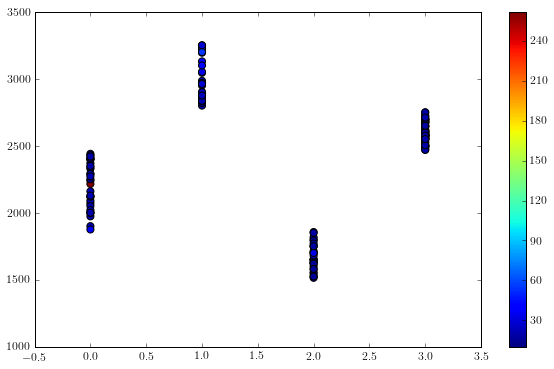

In [334]:
# distribución de grupos vs. altura vs. pesos estadísticos
listcomp=np.loadtxt('listcomp.txt')
plt.figure(figsize=(10,6))
plt.scatter(listcomp[:,6],listcomp[:,5],s=50,c=listcomp[:,0])
plt.colorbar()

(0, 10)

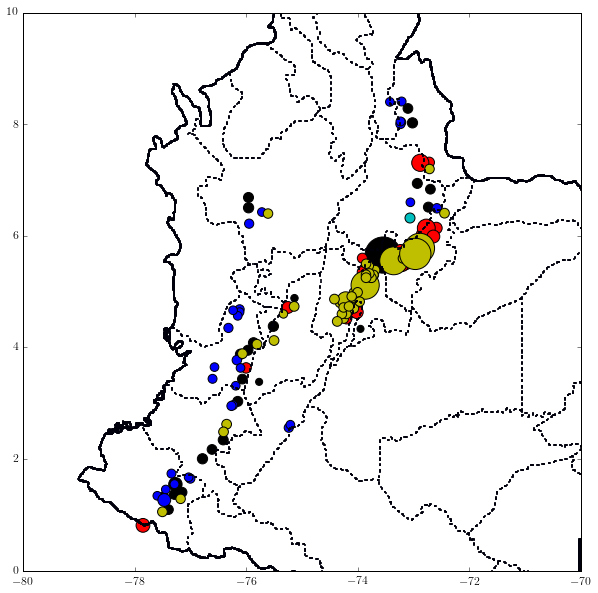

In [361]:
plt.figure(figsize=(10,10))
filter=(listcomp[:,6]==0)
plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],c='k',s=listcomp[:,0][filter]*5)
filter=(listcomp[:,6]==1)
plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],c='r',s=listcomp[:,0][filter]*5)
filter=(listcomp[:,6]==2)
plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],c='b',s=listcomp[:,0][filter]*5)
filter=(listcomp[:,6]==3)
plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],c='y',s=listcomp[:,0][filter]*5)
filter=(listcomp[:,6]==4)
plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],c='g',s=listcomp[:,0][filter]*5)
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.scatter(np.array([-73.06]),np.array([6.3211484]),s=100,c='c')
#plt.colorbar()
plt.xlim(-80,-70)
plt.ylim(0,10)

(0, 10)

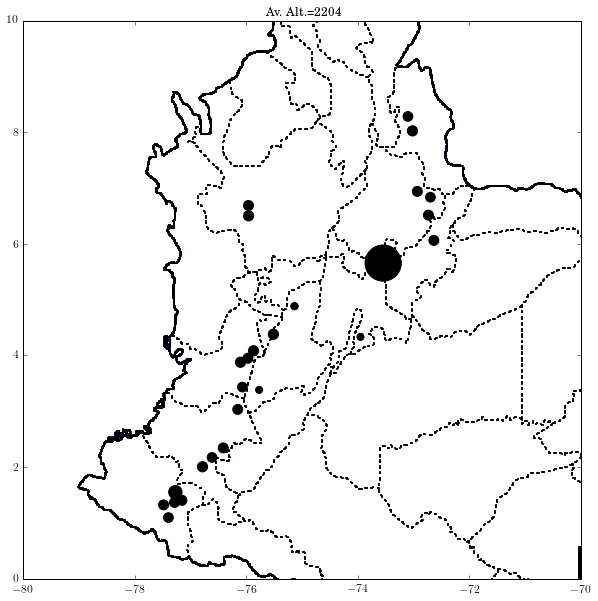

In [336]:
plt.figure(figsize=(10,10))

filter=(listcomp[:,6]==0)
plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],c='k',s=listcomp[:,0][filter]*5)

plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.title('Av. Alt.=%i' % listcomp[:,5][filter].mean())

#plt.colorbar()
plt.xlim(-80,-70)
plt.ylim(0,10)

(0, 10)

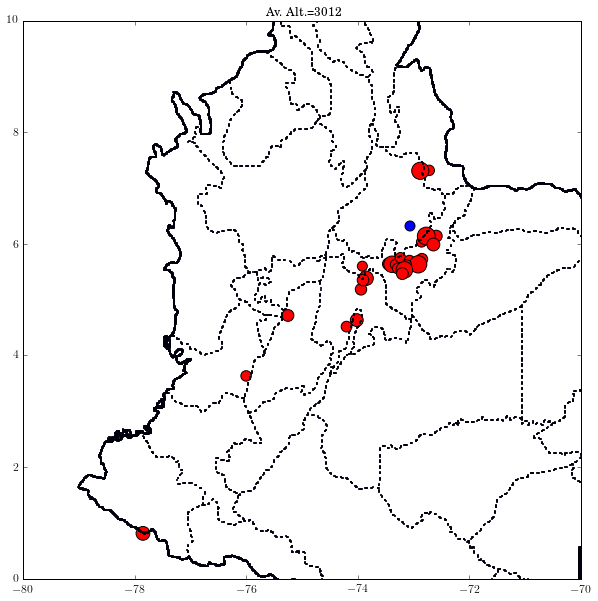

In [359]:
plt.figure(figsize=(10,10))

filter=(listcomp[:,6]==1)
plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],c='r',s=listcomp[:,0][filter]*5)
plt.scatter(np.array([-73.06]),np.array([6.3211484]),s=100,c='b')
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.title('Av. Alt.=%i' % listcomp[:,5][filter].mean())

#plt.colorbar()
plt.xlim(-80,-70)
plt.ylim(0,10)

(0, 10)

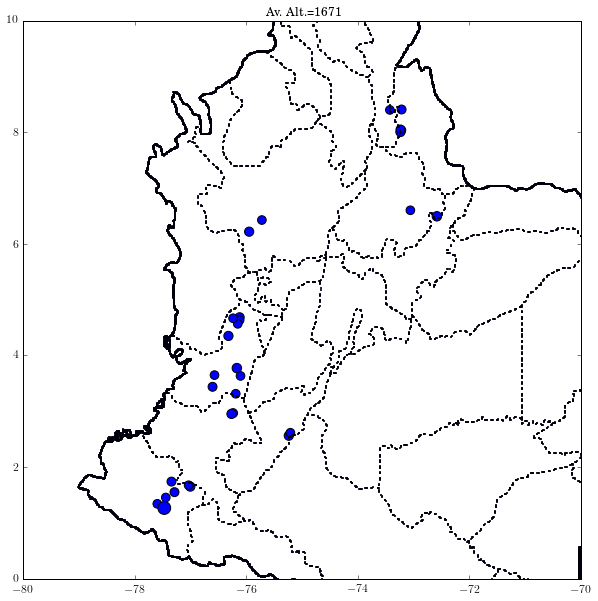

In [339]:
plt.figure(figsize=(10,10))

filter=(listcomp[:,6]==2)
plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],c='b',s=listcomp[:,0][filter]*5)

plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.title('Av. Alt.=%i' % listcomp[:,5][filter].mean())

#plt.colorbar()
plt.xlim(-80,-70)
plt.ylim(0,10)

(0, 10)

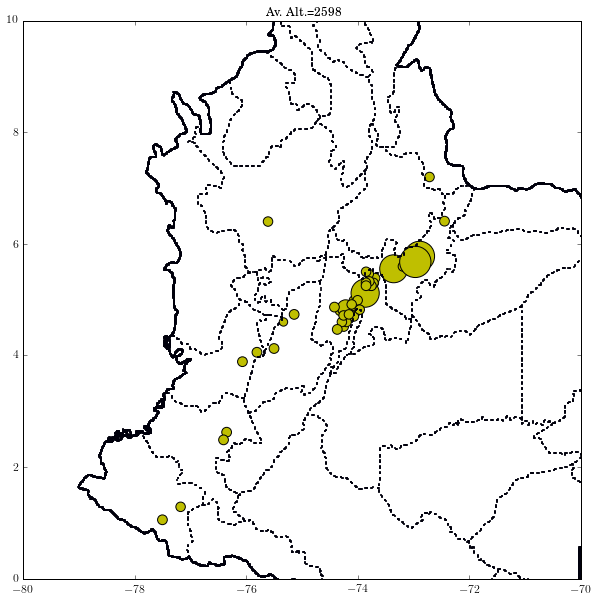

In [363]:
plt.figure(figsize=(10,10))

filter=(listcomp[:,6]==3)
plt.scatter(-listcomp[:,3][filter],-listcomp[:,4][filter],c='y',s=listcomp[:,0][filter]*5)

plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.title('Av. Alt.=%i' % listcomp[:,5][filter].mean())

#plt.colorbar()
plt.xlim(-80,-70)
plt.ylim(0,10)

# Hasta aqui

In [16]:
# Ahora seleccionamos los que cumplen al menos 1 de 3 criterios: humedad, lluvia, y dias con lluvia
DAT3C=np.vstack((DATH,DATL,DATD))
np.savetxt('datos3c.txt',DAT3C)

In [17]:
%%bash
awk '{print $0}' datos3c.txt | sort -n | uniq -c > listam3c.txt
rm datos3c.txt

In [18]:
# generamos una lista con las estaciones que cumplen 1 de 3 criterios, y contamos cuantos de ellos son cumplidos
listam3c=np.loadtxt('listam3c.txt')

In [19]:
# contamos cuantas variables (humedad, lluvia, y dias con lluvia) fueron medidas
df=pd.read_csv('lluvia.csv')
tomados3c=np.zeros(len(listam3c[:,1]))
for i in range(len(listam3c[:,1])):
    for k in range(len(df.CODIGO)):
        if(listam3c[i,1]==df.CODIGO[k]):
            tomados3c[i]+=1
df=pd.read_csv('humedad.csv')
for i in range(len(listam3c[:,1])):
    for k in range(len(df.CODIGO)):
        if(listam3c[i,1]==df.CODIGO[k]):
            tomados3c[i]+=1
df=pd.read_csv('diaslluvia.csv')
for i in range(len(listam3c[:,1])):
    for k in range(len(df.CODIGO)):
        if(listam3c[i,1]==df.CODIGO[k]):
            tomados3c[i]+=1  

In [20]:
# filtramos las que cumplen o pueden cumplir los 3 criterios (es decir, considerando los casos en los que no se midieron algunos de las variables)
pfilter3c=tomados3c-listam3c[:,0]==0
listacorta3c=listam3c[pfilter3c]

In [21]:
# encontramos las estaciones en listacorta3c en las que se tomaron datos de brillo solar
df=pd.read_csv('brillo.csv')
tomados3cB=np.zeros(len(listacorta3c[:,1]))
for i in range(len(listacorta3c[:,1])):
    for k in range(len(df.CODIGO)):
        if(listacorta3c[i,1]==df.CODIGO[k]):
            tomados3cB[i]+=1 

In [22]:
# encontramos las estaciones en listacorta3c que cumplen el criterio de brillo solar
cbrillo3cB=np.zeros(len(listacorta3c[:,1]))
for i in range(len(listacorta3c[:,1])):
    for k in range(len(DATB[:,1])):
        if(listacorta3c[i,1]==DATB[k,0]):
            cbrillo3cB[i]+=1 

In [23]:
# 0=no cumple el criterio de brillo solar, 1=si lo cumple, 2=no fue medido
Brillo=2*(1-tomados3cB)+cbrillo3cB

In [25]:
# tabla de probabilidad (peso) para 3 variables que pueden o no cumplir criterios
def genprob3(cumple):
    if(cumple==3.):
        return 1./8
    if(cumple==2.):
        return (3./8)*(1./4)
    if(cumple==1.):
        return (3./8)*(1./7)

In [26]:
# se multiplica la anterior tabla con la tabla de probabilidad (peso) para el criterio de brillo 
# (casos de 12-24 horas de cielos despejados)
def parseprob3(cumple,brillo):
    if(brillo==2.):
        return genprob3(cumple)*3./4
    if(brillo==1.):
        return genprob3(cumple)*1.
    if(brillo==0.):
        return genprob3(cumple)*1./2

In [27]:
# genera un arreglo con pesos para cada estación
probarr12=np.zeros(len(Brillo))
for i in range(len(Brillo)):
    probarr12[i]=parseprob3(listacorta3c[i,0],Brillo[i])

(-5, 14)

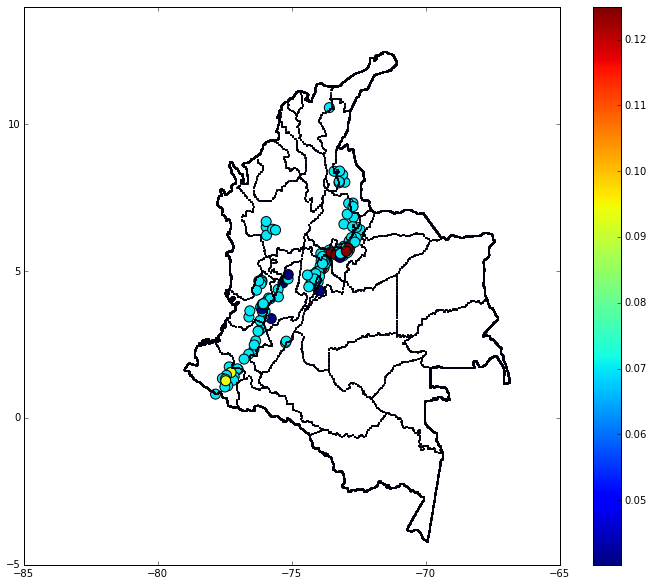

In [29]:
# peso estadístico para cada estación en listacorta3c
plt.figure(figsize=(12,10))
plt.scatter(-listacorta3c[:,2],-listacorta3c[:,3],c=probarr12,s=100)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.xlim(-85,-65)
plt.ylim(-5,14)

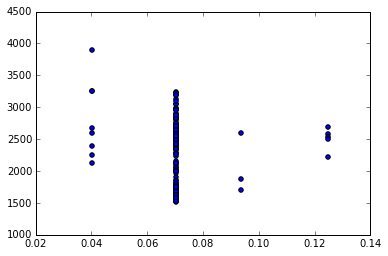

In [30]:
# distribución de pesos est. vs. altura
plt.scatter(probarr12,listacorta3c[:,4])

In [31]:
# generación de lista expandida que incluye pesos enteros para cada estación
lendata12=(probarr12*112*8).sum().astype(int)
wdata12=(probarr12*112*8).astype(int)
listaexp12=np.zeros((lendata12,5))
kcount=0
for i in range(len(probarr12)):        
    for kinx in range(wdata12[i]):
        listaexp12[kinx+kcount,:]=listacorta3c[i,:]
    kcount=kcount+kinx+1   

In [163]:
# clustering para datos sin escalar
# clustering por mixtura gaussiana de la lista expandida, buscando un mínimo local para el criterio de información bayesiano
# el agrupamiento se hace por lon,lat,alt
cv_types = ['spherical', 'tied', 'diag', 'full']
bicold=0
compo=15
BIC=np.zeros((compo+1,4))
kik=0
for cv_type in cv_types:
    for kcomp in np.arange(compo)+1:        
        gmm = GMM(kcomp, covariance_type=cv_type, random_state=0)
        gmm.fit(listaexp12[:,2:5])
#        if bicold<gmm.bic(listaexp12[:,2:5]):
#        print cv_type,kcomp,gmm.bic(X_scaled[:,2:5]);
        BIC[kcomp,kik]=gmm.bic(listaexp12[:,2:5])
        bicold=gmm.bic(listaexp12[:,2:5])
    kik+=1

(150000, 240000)

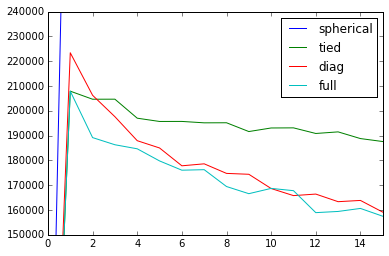

In [172]:
for i, cv_type in zip(range(4),cv_types):
    plt.plot(np.arange(compo+1),BIC[:,i],label=cv_type)
plt.legend()
plt.xlim(0,15)
plt.ylim(150000,240000)
# mínimos locales en 6,9,12 componentes

In [150]:
# re-escalamos los datos para darle más importancia al agrupamiento por alturas (similares pisos térmicos)
# el agrupamiento se hace por lon,lat,alt
from sklearn import preprocessing
X_scaled = preprocessing.scale(listaexp12[:,2:5])

In [160]:
# clustering por mixtura gaussiana de la lista expandida, buscando un mínimo local para el criterio de información bayesiano
# el agrupamiento se hace por lon,lat,alt
# mínimo local en 6 componentes
cv_types = ['spherical', 'tied', 'diag', 'full']
bicold=0
compo=10
BIC=np.zeros((compo+1,4))
kik=0
for cv_type in cv_types:
    for kcomp in np.arange(compo)+1:        
        gmm = GMM(kcomp, covariance_type=cv_type, random_state=0)
        gmm.fit(X_scaled[:,2:5])
#        if bicold<gmm.bic(listaexp12[:,2:5]):
#        print cv_type,kcomp,gmm.bic(X_scaled[:,2:5]);
        BIC[kcomp,kik]=gmm.bic(X_scaled[:,2:5])
        bicold=gmm.bic(X_scaled[:,2:5])
    kik+=1

(23000, 24000)

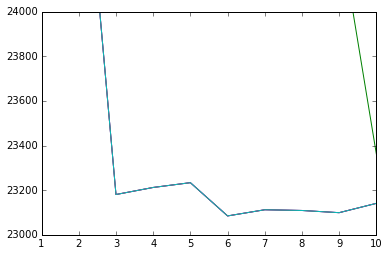

In [155]:
plt.plot(np.arange(compo+1),BIC[:,0])
plt.plot(np.arange(compo+1),BIC[:,1])
plt.plot(np.arange(compo+1),BIC[:,2])
plt.plot(np.arange(compo+1),BIC[:,3])
plt.xlim(1,10)
plt.ylim(23000,24000)

In [120]:
# para los datos sin re-escalar, agrupamiento por mixtura gaussiana de 6 componentes
# para kcomp=9 los importantes son 0,7 pero se mezclan mucho geográficamente
# para kcomp=12 los importantes son 1,2,3,8 pero se mezclan mucho geográficamente 
kcomp=6
gmm = GMM(kcomp, covariance_type='full', random_state=0)
gmm.fit(listaexp12[:,2:5])
cluster_label_stacked12 = gmm.predict(listaexp12[:,2:5])
print kcomp, gmm.bic(listaexp12[:,2:5])
# se almacenan los datos para procesarlos con bash con el fin de colapsar la lista expandida
listastacked12=np.vstack((listaexp12.T,cluster_label_stacked12)).T
np.savetxt('lisstck12.txt',listastacked12)

6 176050.486359


In [121]:
%%bash
uniq -c lisstck12.txt > listcomp12.txt
rm lisstck12.txt

<matplotlib.colorbar.Colorbar instance at 0x7f4290191638>

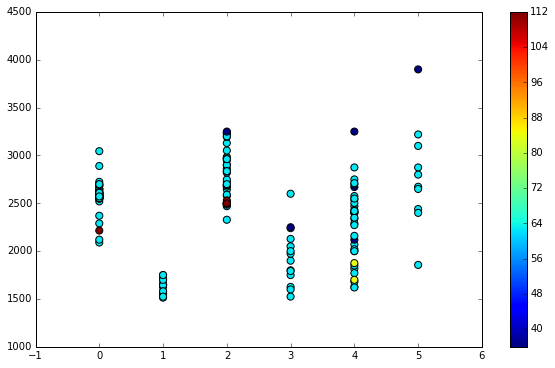

In [122]:
# distribución de grupos vs. altura vs. pesos estadísticos
listcomp12=np.loadtxt('listcomp12.txt')
plt.figure(figsize=(10,6))
plt.scatter(listcomp12[:,6],listcomp12[:,5],c=probarr12*112*8,s=50)
plt.colorbar()

(-5, 14)

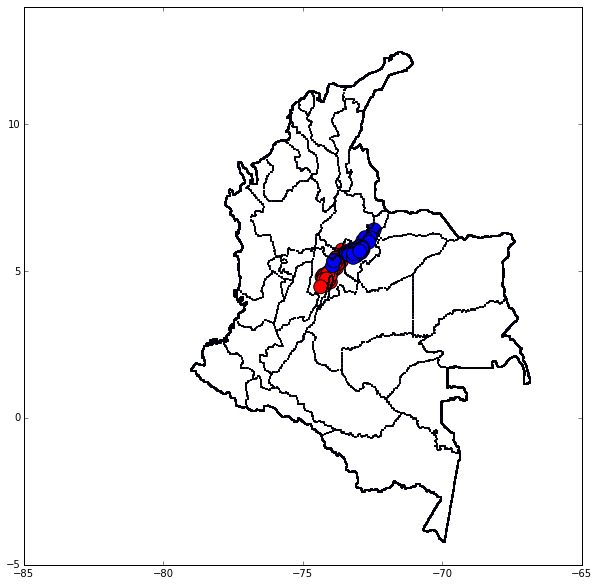

In [123]:
# clusters favoritos (encima de 2000 metros) son 0,2
plt.figure(figsize=(10,10))
#filter=(np.ones(len(listcomp12[:,6]))).astype(bool)
#listcomp12[:,6][filter]
filter=(listcomp12[:,6]==0)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='r',s=probarr12*112*8*3)
filter=(listcomp12[:,6]==2)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='b',s=probarr12*112*8*3)
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-85,-65)
plt.ylim(-5,14)

(4, 6.5)

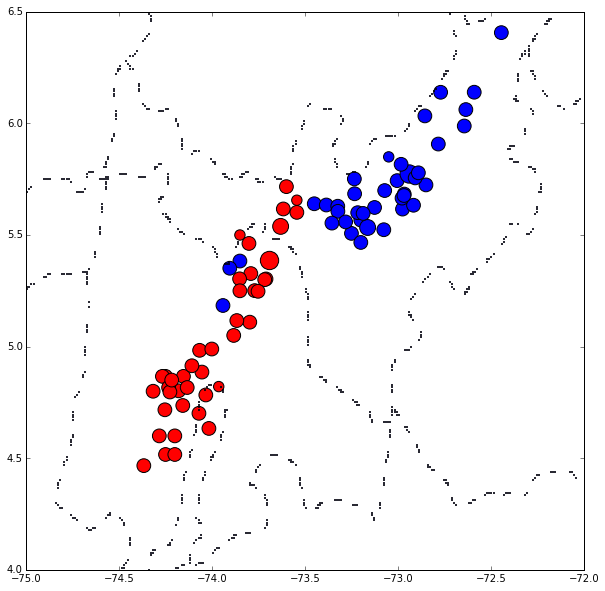

In [124]:
# clusters favoritos (encima de 2000 metros) son 0,2
plt.figure(figsize=(10,10))
#filter=(np.ones(len(listcomp12[:,6]))).astype(bool)
#listcomp12[:,6][filter]
filter=(listcomp12[:,6]==0)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='r',s=probarr12*112*8*3)
filter=(listcomp12[:,6]==2)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='b',s=probarr12*112*8*3)
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-75,-72)
plt.ylim(4,6.5)

(4, 6.5)

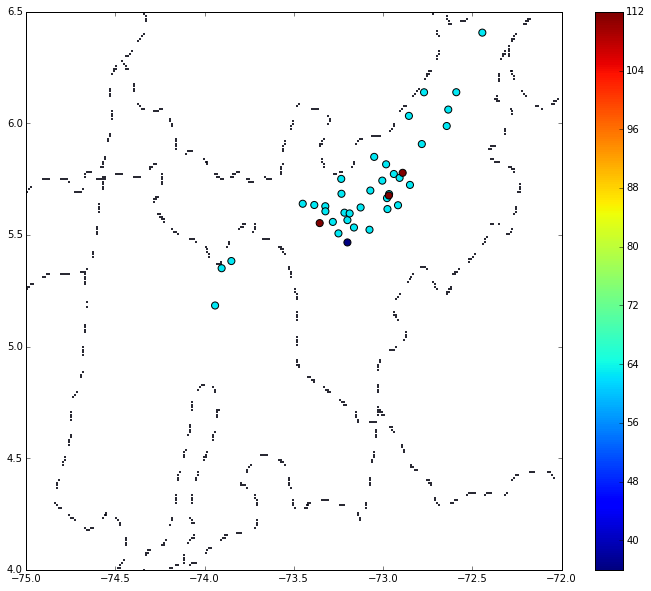

In [132]:
# clusters favoritos (encima de 2000 metros) son 0,2
plt.figure(figsize=(12,10))
#filter=(np.ones(len(listcomp12[:,6]))).astype(bool)
#listcomp12[:,6][filter]
filter=(listcomp12[:,6]==2)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c=probarr12[filter]*112*8,s=50)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#
plt.xlim(-75,-72)
plt.ylim(4,6.5)

(4, 6.5)

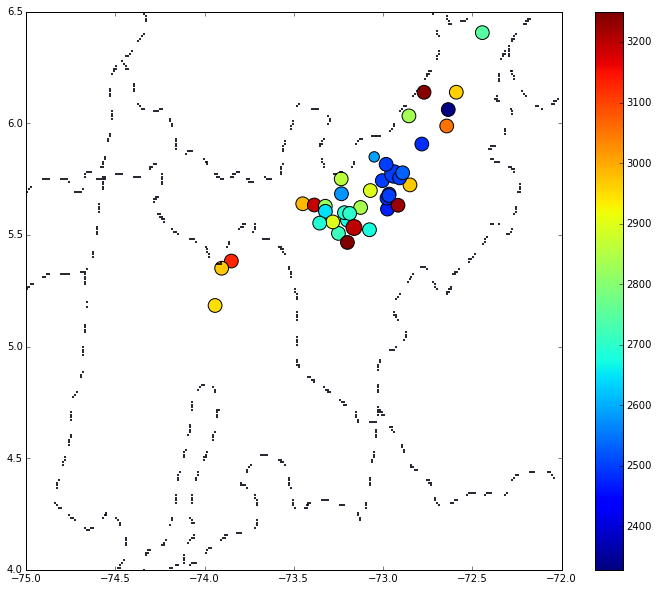

In [125]:
# clusters favoritos (encima de 2000 metros) son 0,2
plt.figure(figsize=(12,10))
#filter=(np.ones(len(listcomp12[:,6]))).astype(bool)
#listcomp12[:,6][filter]

filter=(listcomp12[:,6]==2)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c=listcomp12[:,5][filter],s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.xlim(-75,-72)
plt.ylim(4,6.5)

[  1.  10.]


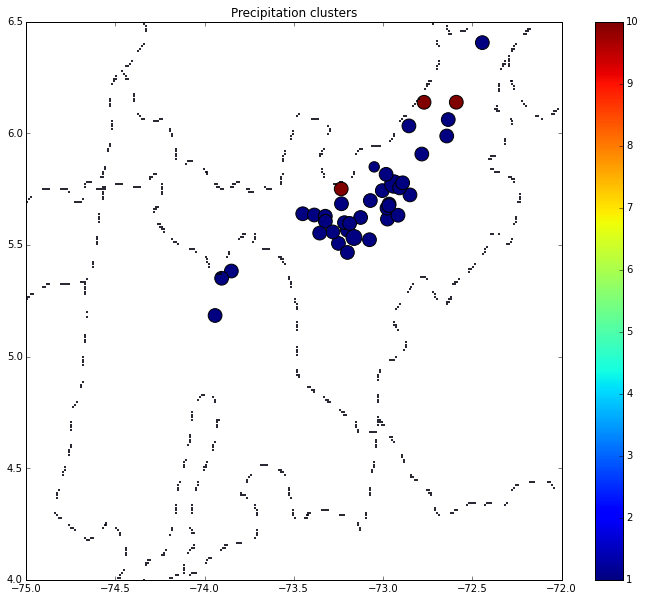

In [126]:
# clusters favoritos (encima de 2500 metros) son 0-cundinamarca y 2-boyaca
# clusters de lluvia: 1 y 10
plt.figure(figsize=(12,10))
filter=(listcomp12[:,6]==2)
list12label=np.zeros(len(listcomp12[filter]))+11
for i in range(len(listcomp12[filter])):
    if((codeL==listcomp12[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelL[codeL==listcomp12[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-75,-72)
plt.ylim(4,6.5)
plt.title("Precipitation clusters")

[  3.   5.  11.]


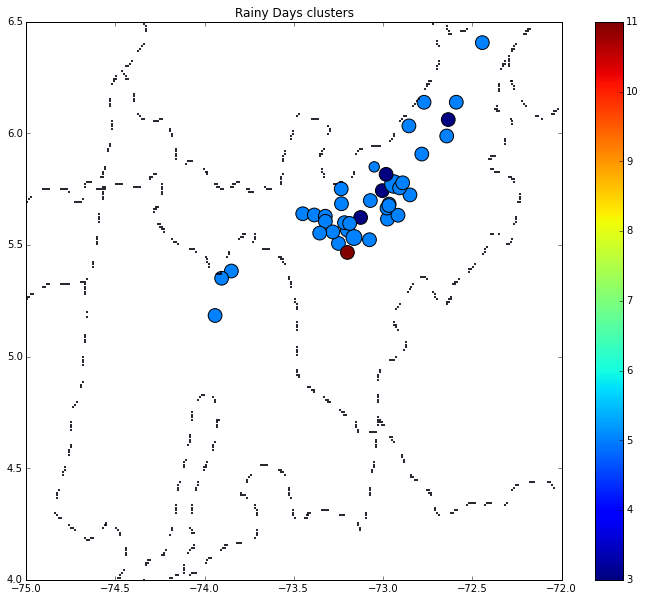

In [127]:
# clusters favoritos (encima de 2500 metros) son 0-cundinamarca y 2-boyaca
# clusters de días con lluvia: 3 y 5
plt.figure(figsize=(12,10))
filter=(listcomp12[:,6]==2)
list12label=np.zeros(len(listcomp12[filter]))+11
for i in range(len(listcomp12[filter])):
    if((codeD==listcomp12[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelD[codeD==listcomp12[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-75,-72)
plt.ylim(4,6.5)
plt.title("Rainy Days clusters")

[  4.  11.]


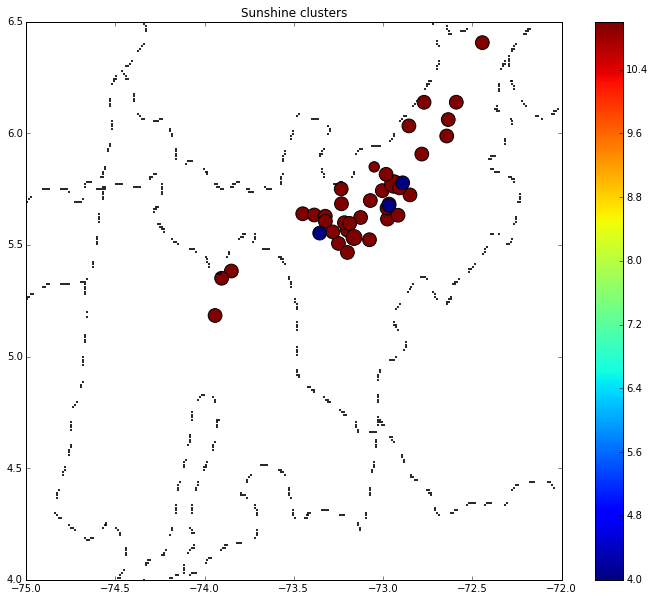

In [128]:
# clusters favoritos (encima de 2500 metros) son 0-cundinamarca y 2-boyaca
# clusters de brillo solar: 
plt.figure(figsize=(12,10))
filter=(listcomp12[:,6]==2)
list12label=np.zeros(len(listcomp12[filter]))+11
for i in range(len(listcomp12[filter])):
    if((codeB==listcomp12[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelB[codeB==listcomp12[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-75,-72)
plt.ylim(4,6.5)
plt.title("Sunshine clusters")

[  1.  11.]


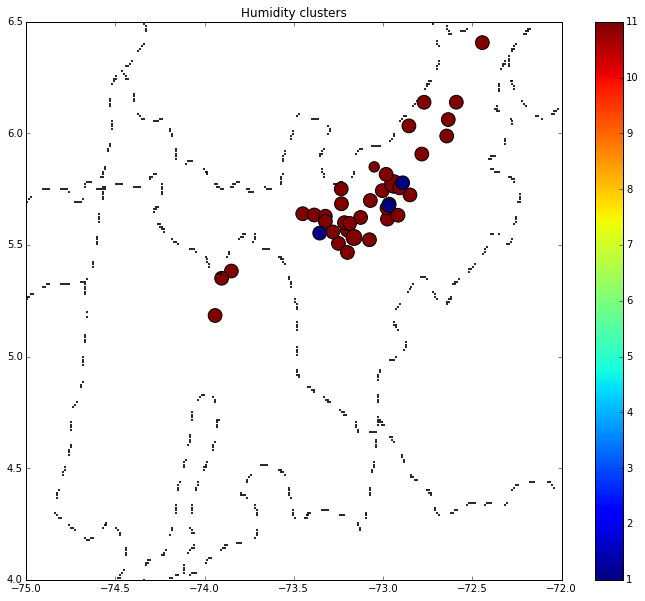

In [111]:
# clusters favoritos (encima de 2500 metros) son 0-cundinamarca y 2-boyaca
# clusters de humedad: 
plt.figure(figsize=(12,10))
filter=(listcomp12[:,6]==2)
list12label=np.zeros(len(listcomp12[filter]))+11
for i in range(len(listcomp12[filter])):
    if((codeH==listcomp12[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelH[codeH==listcomp12[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-75,-72)
plt.ylim(4,6.5)
plt.title("Humidity clusters")

In [156]:
# para los datos re-escalados, agrupamiento por mixtura gaussiana de 6 componentes
kcomp=6
gmm = GMM(kcomp, covariance_type='full', random_state=0)
gmm.fit(X_scaled[:,2:5])
cluster_label_stacked12sc = gmm.predict(X_scaled[:,2:5])
print kcomp, gmm.bic(X_scaled[:,2:5])
# se almacenan los datos para procesarlos con bash con el fin de colapsar la lista expandida
listastacked12sc=np.vstack((listaexp12.T,cluster_label_stacked12sc)).T
np.savetxt('lisstck12sc.txt',listastacked12sc)

6 23084.5792863


In [157]:
%%bash
uniq -c lisstck12sc.txt > listcomp12sc.txt
rm lisstck12sc.txt

(0, 4500.0)

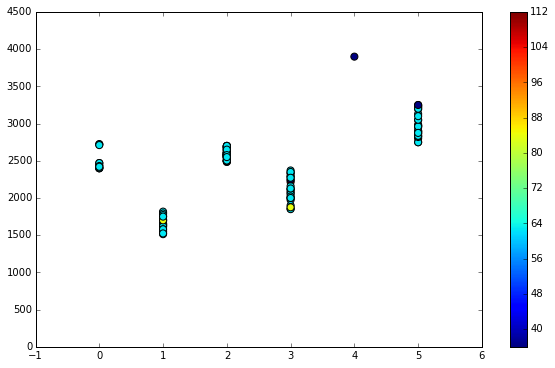

In [158]:
# distribución de grupos vs. altura vs. pesos estadísticos
listcomp12sc=np.loadtxt('listcomp12sc.txt')
plt.figure(figsize=(10,6))
plt.scatter(listcomp12sc[:,6],listcomp12sc[:,5],c=probarr12*112*8,s=50)
plt.colorbar()
plt.ylim(0)

12
28
60


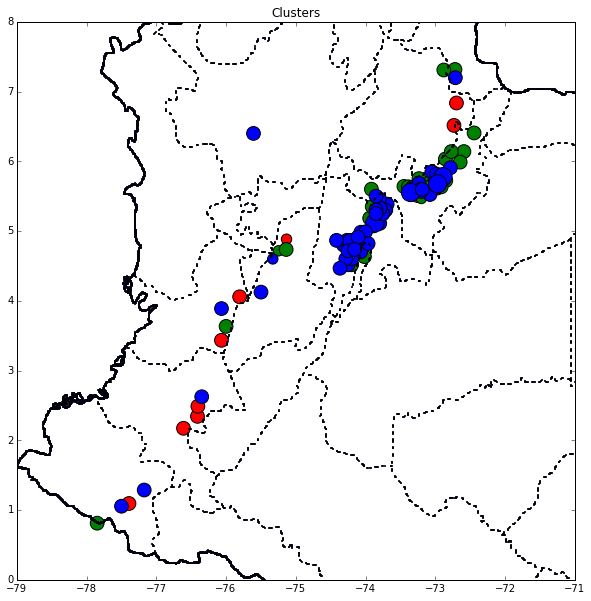

In [235]:
# clusters favoritos (encima de 2500 metros) son 
plt.figure(figsize=(10,10))
#filter=(np.ones(len(listcomp12[:,6]))).astype(bool)
filter=(listcomp12sc[:,6]==0)
print filter.sum()
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='r',s=probarr12[filter]*112*8*3)

filter=(listcomp12sc[:,6]==5)
print filter.sum()
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='g',s=probarr12[filter]*112*8*3)
filter=(listcomp12sc[:,6]==2)
print filter.sum()
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='b',s=probarr12[filter]*112*8*3)
plt.scatter(colvec[:,0],colvec[:,1],s=1)

plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title('Clusters')

61.0714285714


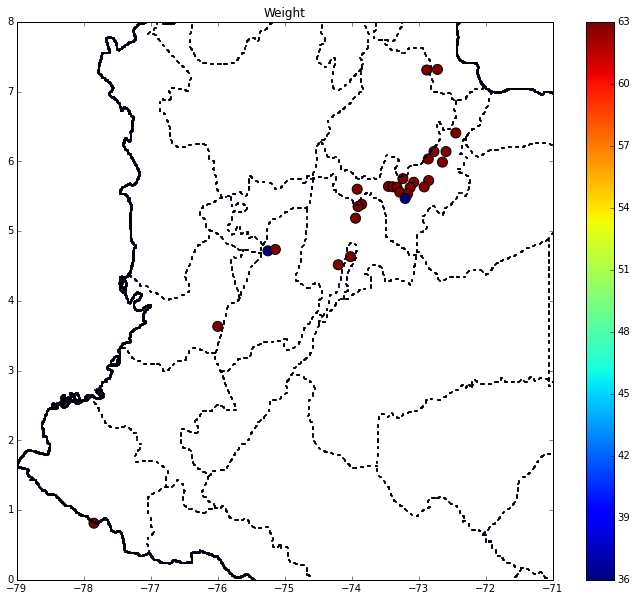

In [210]:
# clusters favoritos (encima de 2000 metros) son 
plt.figure(figsize=(12,10))
#filter=(np.ones(len(listcomp12[:,6]))).astype(bool)
#listcomp12[:,6][filter]
filter=(listcomp12sc[:,6]==5)
plt.scatter(-listcomp12sc[:,3][filter],-listcomp12sc[:,4][filter],c=probarr12[filter]*112*8,s=100)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)
print (probarr12[filter]*112*8).mean()
#
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title('Weight')

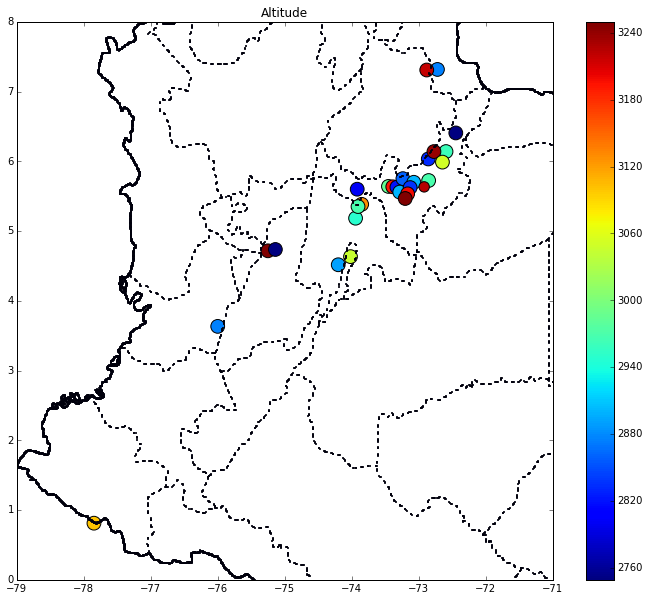

In [214]:
# clusters favoritos (encima de 2000 metros) son 
plt.figure(figsize=(12,10))
#filter=(np.ones(len(listcomp12[:,6]))).astype(bool)
#listcomp12[:,6][filter]

filter=(listcomp12sc[:,6]==5)
plt.scatter(-listcomp12sc[:,3][filter],-listcomp12sc[:,4][filter],c=listcomp12sc[:,5][filter],s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title('Altitude')

[  1.   6.  10.]


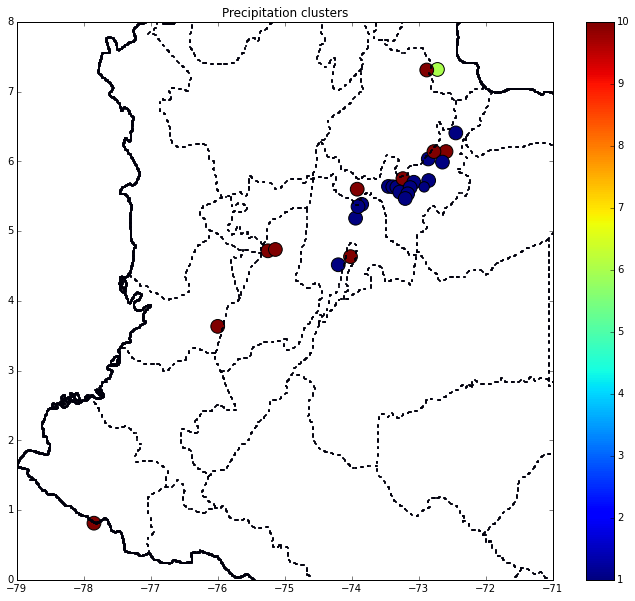

In [193]:
# clusters favoritos (encima de 2500 metros) son 
# clusters de lluvia: 
plt.figure(figsize=(12,10))
filter=(listcomp12sc[:,6]==5)
list12label=np.zeros(len(listcomp12sc[filter]))+11
for i in range(len(listcomp12sc[filter])):
    if((codeL==listcomp12sc[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelL[codeL==listcomp12sc[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12sc[:,3][filter],-listcomp12sc[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title("Precipitation clusters")

[  3.   5.  11.]


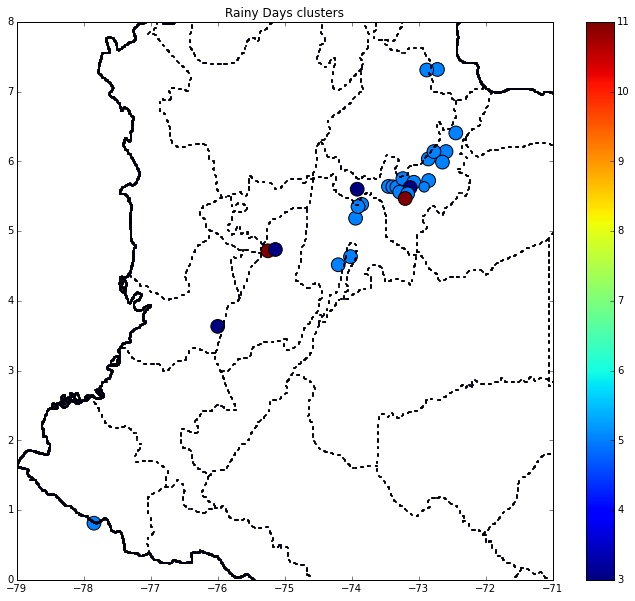

In [197]:
# clusters favoritos (encima de 2500 metros) son
# clusters de días con lluvia: 
plt.figure(figsize=(12,10))
filter=(listcomp12sc[:,6]==5)
list12label=np.zeros(len(listcomp12sc[filter]))+11
for i in range(len(listcomp12sc[filter])):
    if((codeD==listcomp12sc[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelD[codeD==listcomp12sc[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12sc[:,3][filter],-listcomp12sc[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title("Rainy Days clusters")

[ 11.]


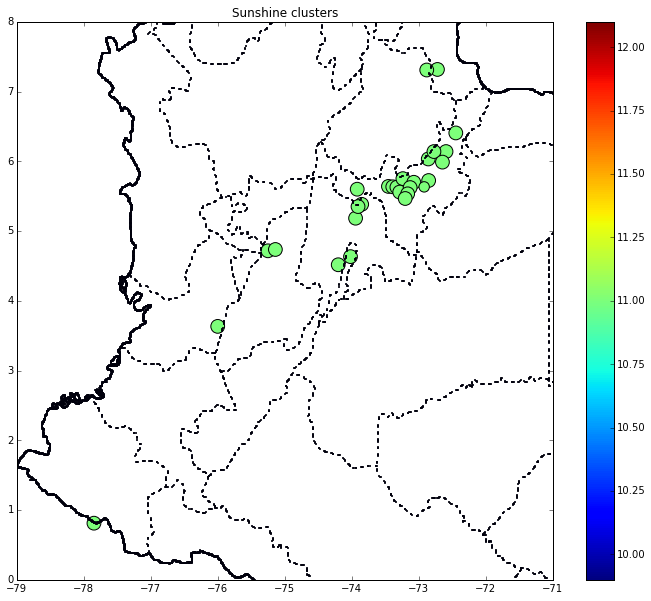

In [202]:
# clusters favoritos (encima de 2500 metros) son 
# clusters de brillo solar: 
plt.figure(figsize=(12,10))
filter=(listcomp12sc[:,6]==5)
list12label=np.zeros(len(listcomp12sc[filter]))+11
for i in range(len(listcomp12sc[filter])):
    if((codeB==listcomp12sc[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelB[codeB==listcomp12sc[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12sc[:,3][filter],-listcomp12sc[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title("Sunshine clusters")

[ 11.]


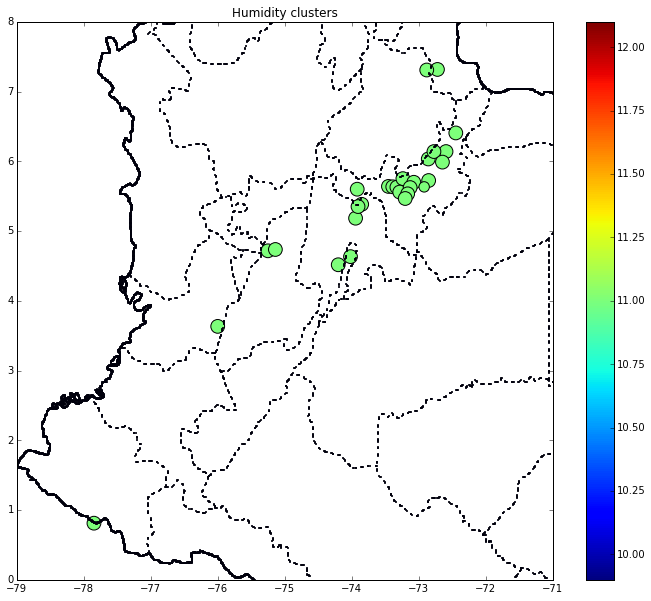

In [205]:
# clusters favoritos (encima de 2500 metros) son 0-cundinamarca y 2-boyaca
# clusters de humedad: 
plt.figure(figsize=(12,10))
filter=(listcomp12sc[:,6]==5)
list12label=np.zeros(len(listcomp12sc[filter]))+11
for i in range(len(listcomp12sc[filter])):
    if((codeH==listcomp12sc[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelH[codeH==listcomp12sc[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12sc[:,3][filter],-listcomp12sc[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title("Humidity clusters")

65.7166666667


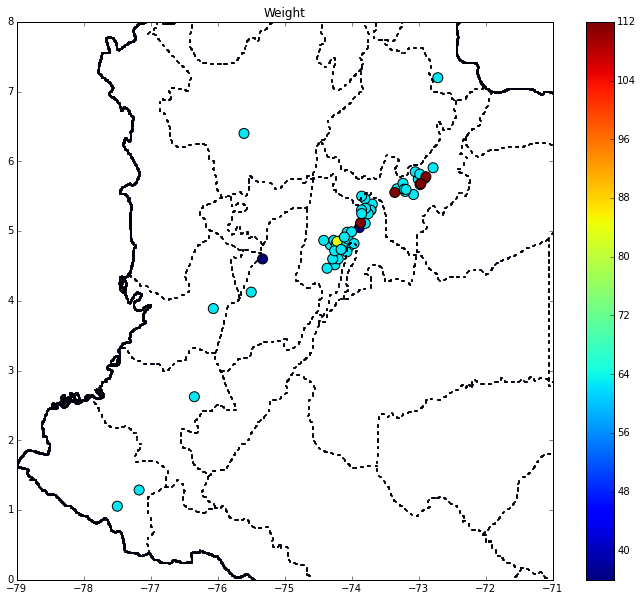

In [212]:
# clusters favoritos (encima de 2000 metros) son 
plt.figure(figsize=(12,10))
#filter=(np.ones(len(listcomp12[:,6]))).astype(bool)
#listcomp12[:,6][filter]
filter=(listcomp12sc[:,6]==2)
plt.scatter(-listcomp12sc[:,3][filter],-listcomp12sc[:,4][filter],c=probarr12[filter]*112*8,s=100)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)
print (probarr12[filter]*112*8).mean()

#
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title('Weight')

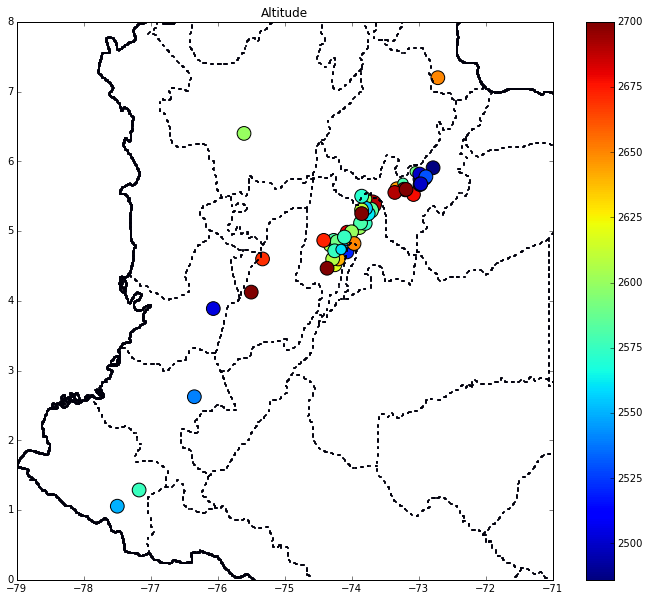

In [215]:
# clusters favoritos (encima de 2000 metros) son 
plt.figure(figsize=(12,10))
#filter=(np.ones(len(listcomp12[:,6]))).astype(bool)
#listcomp12[:,6][filter]

filter=(listcomp12sc[:,6]==2)
plt.scatter(-listcomp12sc[:,3][filter],-listcomp12sc[:,4][filter],c=listcomp12sc[:,5][filter],s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title('Altitude')

[  1.   6.  10.]


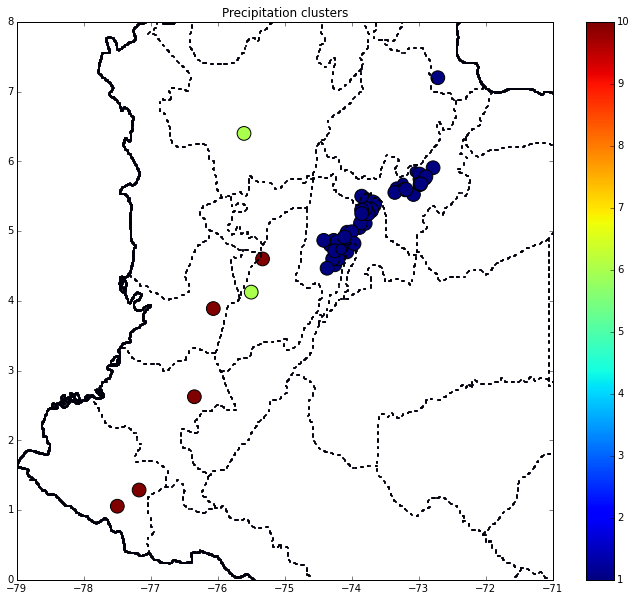

In [194]:
# clusters favoritos (encima de 2500 metros) son 
# clusters de lluvia: 
plt.figure(figsize=(12,10))
filter=(listcomp12sc[:,6]==2)
list12label=np.zeros(len(listcomp12sc[filter]))+11
for i in range(len(listcomp12sc[filter])):
    if((codeL==listcomp12sc[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelL[codeL==listcomp12sc[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12sc[:,3][filter],-listcomp12sc[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title("Precipitation clusters")

[  3.   5.  11.]


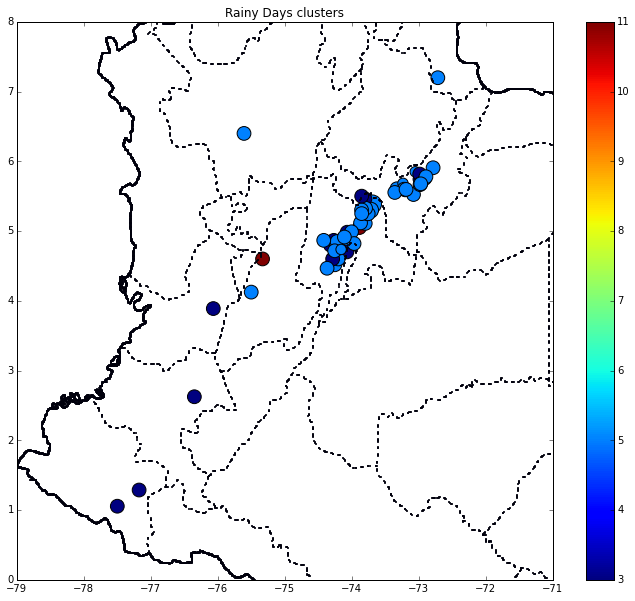

In [198]:
# clusters favoritos (encima de 2500 metros) son
# clusters de días con lluvia: 
plt.figure(figsize=(12,10))
filter=(listcomp12sc[:,6]==2)
list12label=np.zeros(len(listcomp12sc[filter]))+11
for i in range(len(listcomp12sc[filter])):
    if((codeD==listcomp12sc[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelD[codeD==listcomp12sc[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12sc[:,3][filter],-listcomp12sc[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title("Rainy Days clusters")

[  4.  11.]


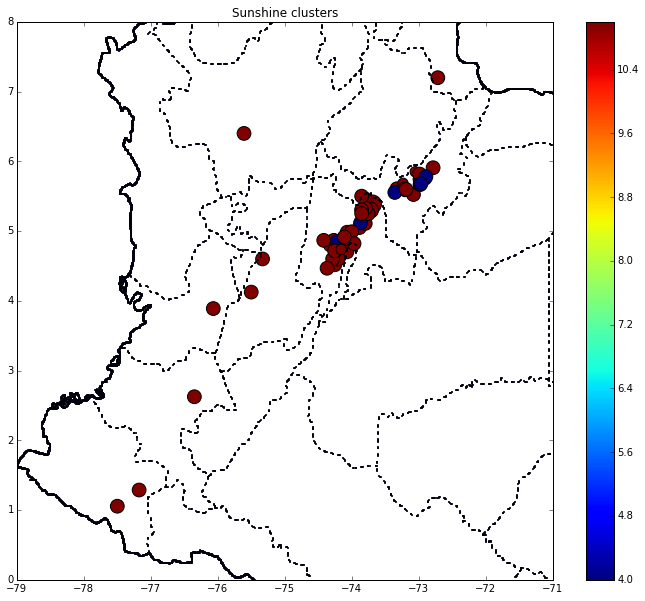

In [203]:
# clusters favoritos (encima de 2500 metros) son 
# clusters de brillo solar: 
plt.figure(figsize=(12,10))
filter=(listcomp12sc[:,6]==2)
list12label=np.zeros(len(listcomp12sc[filter]))+11
for i in range(len(listcomp12sc[filter])):
    if((codeB==listcomp12sc[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelB[codeB==listcomp12sc[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12sc[:,3][filter],-listcomp12sc[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title("Sunshine clusters")

[  1.  11.]


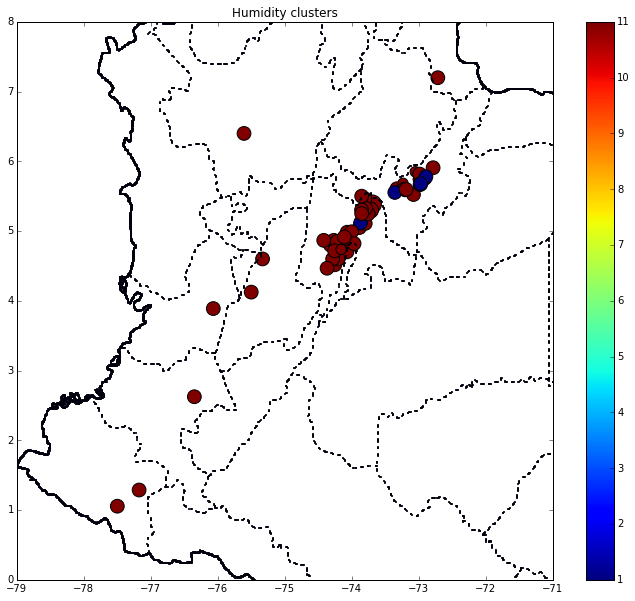

In [206]:
# clusters favoritos (encima de 2500 metros) son 0-cundinamarca y 2-boyaca
# clusters de humedad: 
plt.figure(figsize=(12,10))
filter=(listcomp12sc[:,6]==2)
list12label=np.zeros(len(listcomp12sc[filter]))+11
for i in range(len(listcomp12sc[filter])):
    if((codeH==listcomp12sc[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelH[codeH==listcomp12sc[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12sc[:,3][filter],-listcomp12sc[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title("Humidity clusters")

60.75


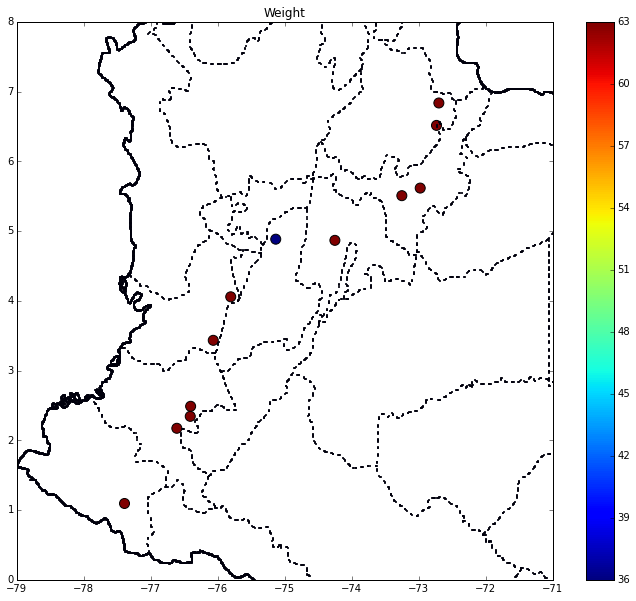

In [213]:
# clusters favoritos (encima de 2000 metros) son 
plt.figure(figsize=(12,10))
#filter=(np.ones(len(listcomp12[:,6]))).astype(bool)
#listcomp12[:,6][filter]
filter=(listcomp12sc[:,6]==0)
plt.scatter(-listcomp12sc[:,3][filter],-listcomp12sc[:,4][filter],c=probarr12[filter]*112*8,s=100)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)
print (probarr12[filter]*112*8).mean()

#
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title('Weight')

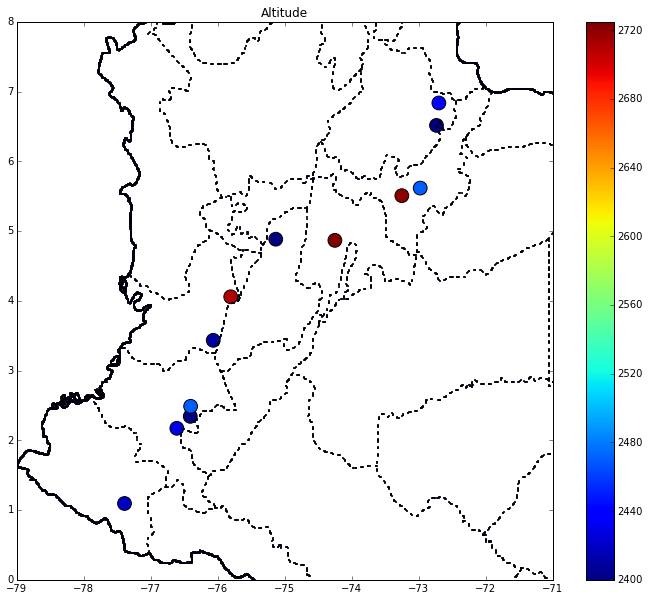

In [216]:
# clusters favoritos (encima de 2000 metros) son 
plt.figure(figsize=(12,10))
#filter=(np.ones(len(listcomp12[:,6]))).astype(bool)
#listcomp12[:,6][filter]

filter=(listcomp12sc[:,6]==0)
plt.scatter(-listcomp12sc[:,3][filter],-listcomp12sc[:,4][filter],c=listcomp12sc[:,5][filter],s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title('Altitude')

[  1.   6.  10.]


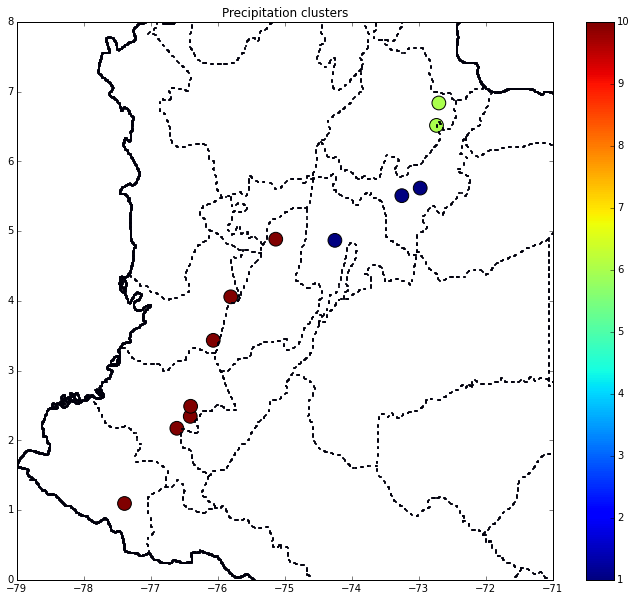

In [195]:
# clusters favoritos (encima de 2500 metros) son 
# clusters de lluvia: 
plt.figure(figsize=(12,10))
filter=(listcomp12sc[:,6]==0)
list12label=np.zeros(len(listcomp12sc[filter]))+11
for i in range(len(listcomp12sc[filter])):
    if((codeL==listcomp12sc[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelL[codeL==listcomp12sc[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12sc[:,3][filter],-listcomp12sc[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title("Precipitation clusters")

[  3.   5.  11.]


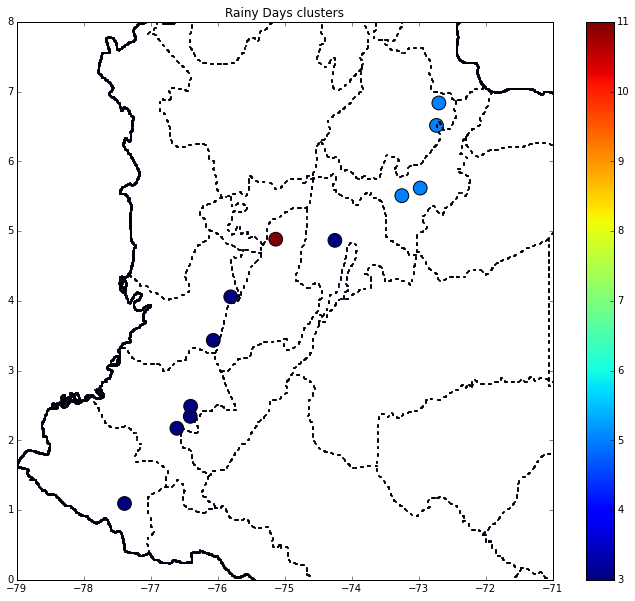

In [199]:
# clusters favoritos (encima de 2500 metros) son
# clusters de días con lluvia: 
plt.figure(figsize=(12,10))
filter=(listcomp12sc[:,6]==0)
list12label=np.zeros(len(listcomp12sc[filter]))+11
for i in range(len(listcomp12sc[filter])):
    if((codeD==listcomp12sc[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelD[codeD==listcomp12sc[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12sc[:,3][filter],-listcomp12sc[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title("Rainy Days clusters")

[ 11.]


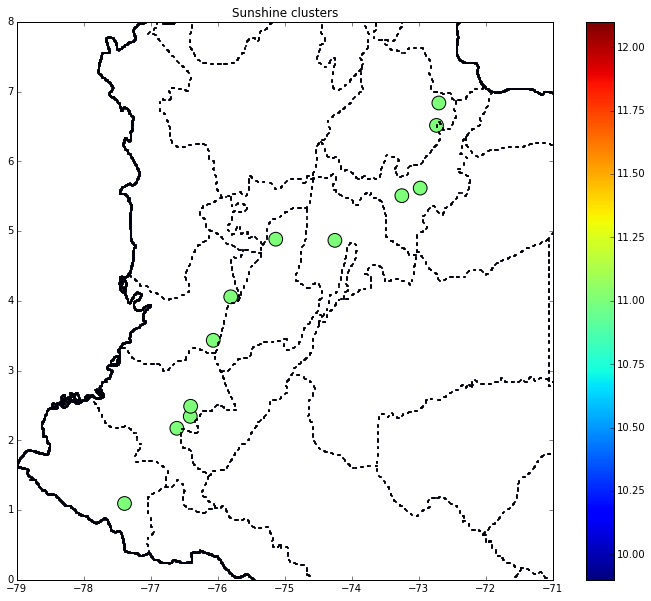

In [204]:
# clusters favoritos (encima de 2500 metros) son 
# clusters de brillo solar: 
plt.figure(figsize=(12,10))
filter=(listcomp12sc[:,6]==0)
list12label=np.zeros(len(listcomp12sc[filter]))+11
for i in range(len(listcomp12sc[filter])):
    if((codeB==listcomp12sc[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelB[codeB==listcomp12sc[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12sc[:,3][filter],-listcomp12sc[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title("Sunshine clusters")

[ 11.]


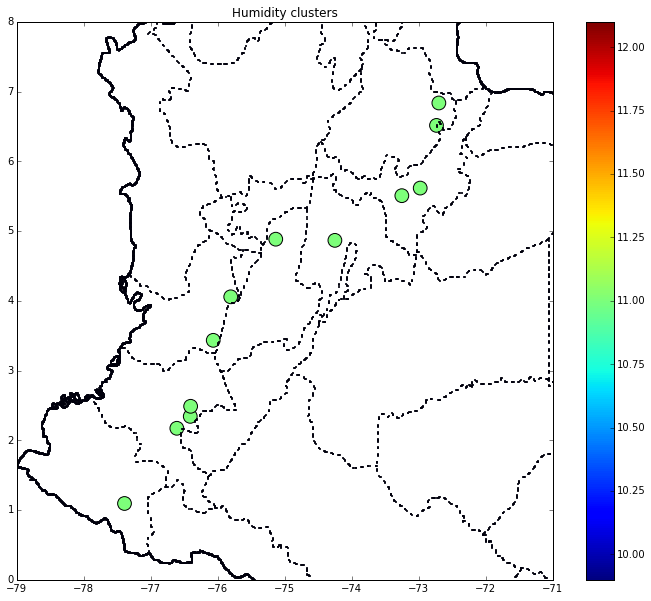

In [231]:
# clusters favoritos (encima de 2500 metros) son 0-cundinamarca y 2-boyaca
# clusters de humedad: 
plt.figure(figsize=(12,10))
filter=(listcomp12sc[:,6]==0)
list12label=np.zeros(len(listcomp12sc[filter]))+11
for i in range(len(listcomp12sc[filter])):
    if((codeH==listcomp12sc[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelH[codeH==listcomp12sc[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12sc[:,3][filter],-listcomp12sc[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-79,-71)
plt.ylim(0,8)
plt.title("Humidity clusters")

# Desde aqui

In [238]:
# Alex Amaral-Rogers' Gaussian Kernel Contour generator
#returns the co-added gaussian kernels grid, and an array of numbers equaling the levels corresponding to the input sigma array.

#the inputs to the function is
#x = array of x data
#y = array of y data (must be the same size as x)
#x1,x2, y1,y2 the limits of the region in which you wish the plot to be.
#N the number of grid points in the axis. You can change this to be Nx, Ny if you preferred.
#sig = list of contour levels you want to plot in terms of sigma levels i.e. [0.5, 1, 2.0] is 0.5 sigma, 1 sigma, 2 sigma levels.


from scipy.stats import gaussian_kde
from scipy.special import erf

def CONTOURP(x, x1, x2, y, y1, y2, N, sig):
    xx = np.linspace(x1, x2, N)
    yy = np.linspace(y1, y2, N)

    XX, YY = np.meshgrid(xx, yy)
    values = np.vstack([x, y])
    positions = np.vstack([XX.ravel(), YY.ravel()])
    kernel = gaussian_kde(values)
    f = np.reshape(kernel(positions).T, XX.shape)

    PCT = 1.0 - np.cumsum(np.sort(f.ravel()))/np.sum(f)
    NN = np.sort(f.ravel())
    SO = [ ]
    for s in sig:
        SO += [NN[(np.abs(PCT - erf(s/np.sqrt(2.0)))).argmin()]]

    return f, SO

In [239]:
# Obtenemos los datos para hacer el contorno de densidad de datos
lnmin=-85
lnmax=-65
ltmin=-5
ltmax=14
nmesh=200
sigarray=[1.,2.]
CONT=CONTOURP(-EST[:,2],lnmin,lnmax,-EST[:,3],ltmin,ltmax,nmesh,sigarray);
xmesh=np.linspace(lnmin,lnmax,nmesh)
ymesh=np.linspace(ltmin,ltmax,nmesh)
Xmesh,Ymesh=np.meshgrid(xmesh,ymesh)

(-5, 14)

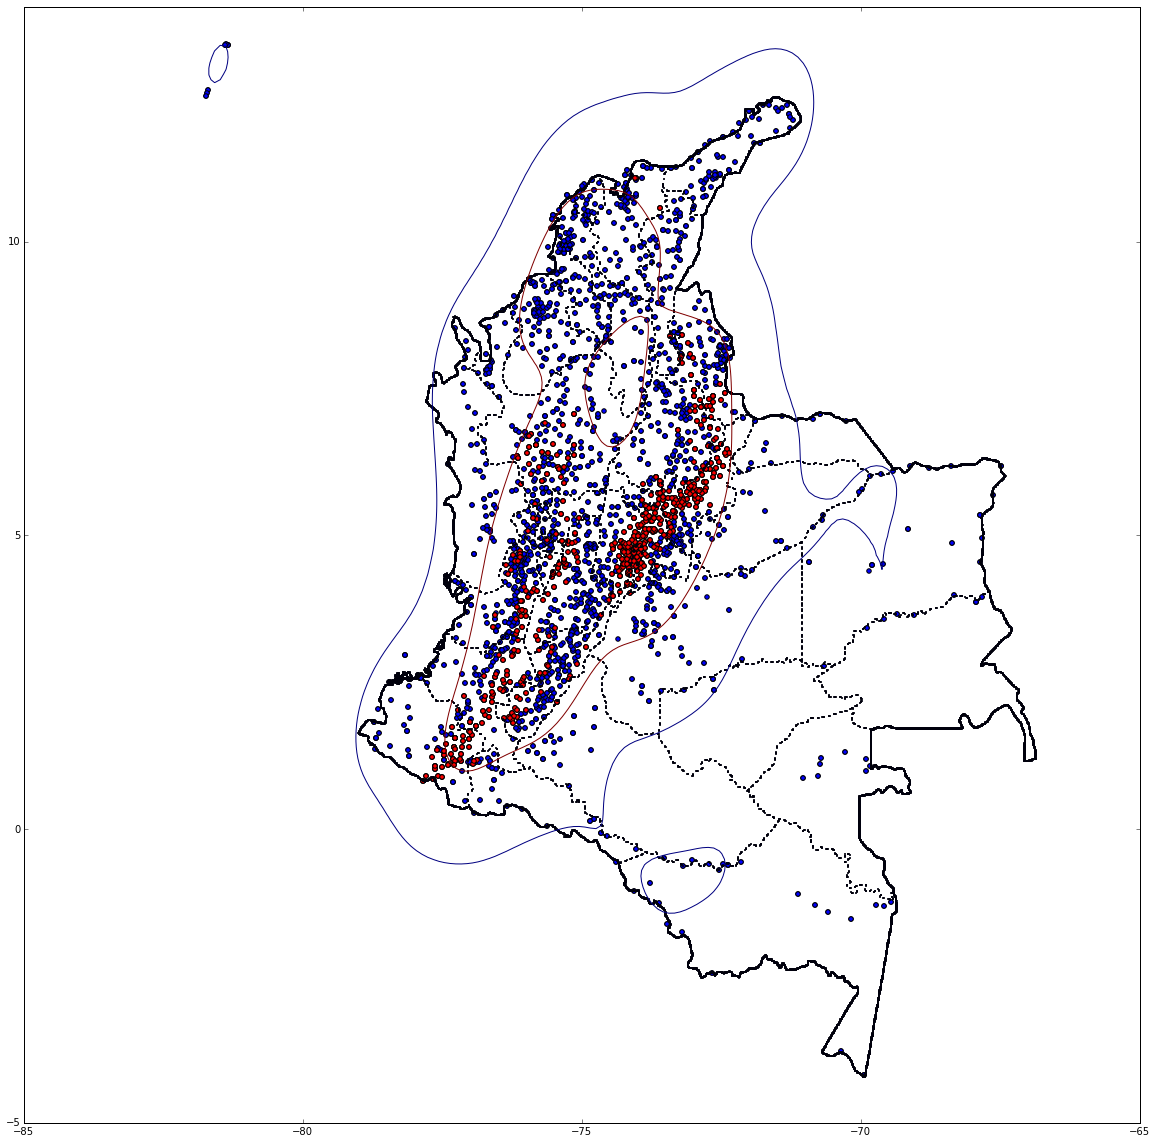

In [244]:
# contornos + azules= todas las estaciones dentro de sigarray=1,2 sigma
# rojos = cumplen al menos una de nuestras condiciones
plt.figure(figsize=(20,20))
plt.contour(Xmesh,Ymesh,CONT[0], levels = CONT[1])
plt.scatter(-LonT, -LatT)
plt.scatter(-DATT[:,1],-DATT[:,2],c='r')
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.xlim(-85,-65)
plt.ylim(-5,14)

In [833]:
# Obtenemos los datos para hacer el contorno de densidad de datos
lnmin=-85
lnmax=-65
ltmin=-5
ltmax=14
nmesh=200
sigarray=[1.,2.]
filter=(EST[:,0]==4)
CONT=CONTOURP(-EST[:,2][filter],lnmin,lnmax,-EST[:,3][filter],ltmin,ltmax,nmesh,sigarray);
xmesh=np.linspace(lnmin,lnmax,nmesh)
ymesh=np.linspace(ltmin,ltmax,nmesh)
Xmesh,Ymesh=np.meshgrid(xmesh,ymesh)

(-5, 14)

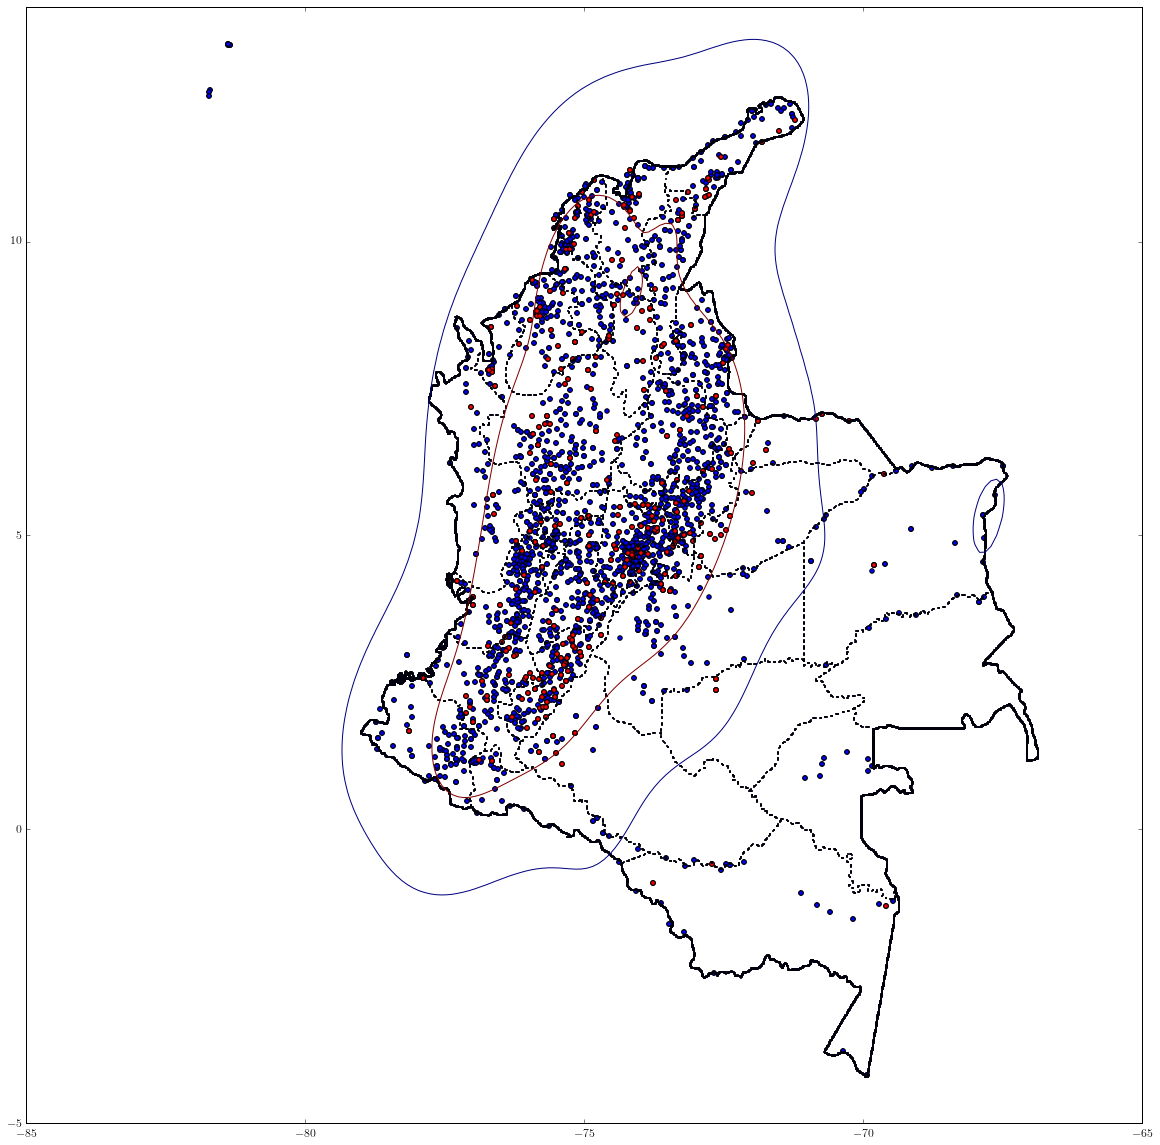

In [838]:
# contornos + azules= todas las estaciones dentro de sigarray=1,2 sigma
# rojos = cumplen al menos una de nuestras condiciones
plt.figure(figsize=(20,20))
plt.contour(Xmesh,Ymesh,CONT[0], levels = CONT[1])
plt.scatter(-LonT, -LatT)
plt.scatter(-LonT[filter], -LatT[filter],c='r')
#plt.scatter(-DATT[:,1],-DATT[:,2],c='r')
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.xlim(-85,-65)
plt.ylim(-5,14)

In [840]:
for i in range(5):
    print (EST[:,0]==i).sum()

0
29
1565
138
314


In [843]:
EST[:,2].shape

(2046,)

In [844]:
LonT.shape

(4829,)